Epoch 1/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.2465 - val_loss: 0.2437 - learning_rate: 1.0000e-04
Epoch 2/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.2320 - val_loss: 0.2299 - learning_rate: 1.0000e-04
Epoch 3/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.2125 - val_loss: 0.2155 - learning_rate: 1.0000e-04
Epoch 4/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.2030 - val_loss: 0.2034 - learning_rate: 1.0000e-04
Epoch 5/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.1906 - val_loss: 0.1928 - learning_rate: 1.0000e-04
Epoch 6/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.1787 - val_loss: 0.1834 - learning_rate: 1.0000e-04
Epoch 7/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.1702 - val_loss: 0.1745 - learning_rate: 1.0000e-04
Epoch 8/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.1622 - val_loss: 0.1665 - learning_rate: 1.0000e-04
Epoch 9/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.1537 - val_loss: 

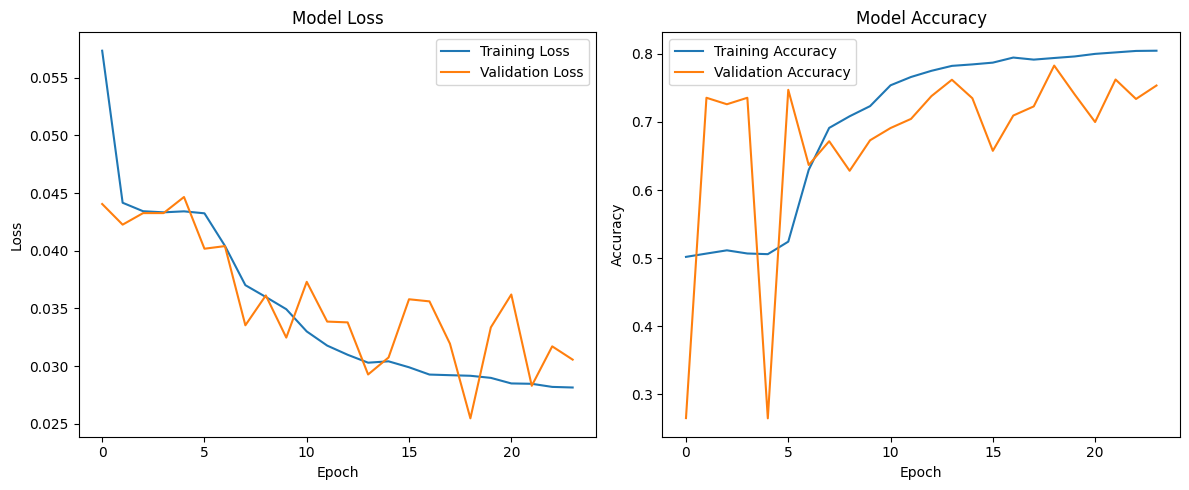

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import ADASYN
import joblib
import matplotlib.pyplot as plt

def mish(x):
    return x * tf.math.tanh(tf.math.softplus(x))

tf.keras.utils.get_custom_objects().update({'mish': tf.keras.layers.Activation(mish)})

def preprocess_data(file_path, test_size=0.2, val_size=0.25, random_state=42):
    df = pd.read_csv(file_path)
    y = df['Attack_label']
    X = df.drop(['Attack_label'], axis=1)
    
    # Outlier removal
    Q1, Q3 = X.quantile(0.25), X.quantile(0.75)
    IQR = Q3 - Q1
    mask = ~((X < (Q1 - 3 * IQR)) | (X > (Q3 + 3 * IQR))).any(axis=1)
    X, y = X[mask], y[mask]
    
    # Stratified split into train+val and test
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y)
    
    # Stratified split of train_val into train and validation
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_size/(1-test_size), 
        random_state=random_state, stratify=y_train_val)
    
    # Robust scaling
    scaler = RobustScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    joblib.dump(scaler, 'robust_scaler.pkl')
    
    return X_train, X_val, X_test, y_train, y_val, y_test

class AdaptiveNIDSLayer1:
    def __init__(self, input_dim, latent_dim=16):
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.model = self._build_autoencoder()

    def _build_autoencoder(self):
        inputs = layers.Input(shape=(self.input_dim,))
        x = layers.BatchNormalization()(inputs)
        x = layers.Reshape((-1, 1))(x)
        
        # Encoder
        conv1 = layers.Conv1D(16, 3, activation='relu', padding='same')(x)
        conv2 = layers.Conv1D(32, 3, activation='relu', padding='same')(conv1)
        res = layers.Conv1D(32, 1, padding='same')(conv1)
        x = layers.Add()([conv2, res])
        x = layers.GlobalAveragePooling1D(name="gap_layer")(x)
        x = layers.Dense(64, activation=mish, kernel_regularizer=regularizers.l1(0.0005))(x)
        x = layers.Dropout(0.3)(x)
        encoded = layers.Dense(self.latent_dim, activation='linear')(x)
        
        # Decoder
        x = layers.RepeatVector(self.input_dim)(encoded)
        x = layers.LSTM(self.latent_dim * 2, return_sequences=True, recurrent_dropout=0.25)(x)
        decoded = layers.TimeDistributed(layers.Dense(1, activation='linear'))(x)
        decoded = layers.Flatten()(decoded)
        
        autoencoder = keras.Model(inputs=inputs, outputs=decoded)
        autoencoder.compile(optimizer=keras.optimizers.Adam(1e-4), loss='mse')
        return autoencoder

    def train(self, X_train, X_val, epochs=50):
        lr_schedule = keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
        early_stopping = keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=10, restore_best_weights=True)
        return self.model.fit(
            X_train, X_train, epochs=epochs, batch_size=64,
            validation_data=(X_val, X_val), callbacks=[lr_schedule, early_stopping])

    def detect_anomalies(self, X_data, threshold=0.03):  # Increased threshold
        reconstructed = self.model.predict(X_data)
        errors = np.mean(np.square(X_data - reconstructed), axis=1)
        return X_data[errors > threshold], np.where(errors > threshold)[0]

    def extract_features(self, X_anomalies):
        feature_extractor = keras.Model(
            inputs=self.model.input, outputs=self.model.get_layer("gap_layer").output)
        return feature_extractor.predict(X_anomalies)

def apply_pca(X_features, variance_threshold=0.99):  # Increased variance retention
    pca = PCA(n_components=variance_threshold)
    X_features_pca = pca.fit_transform(X_features)
    joblib.dump(pca, 'pca_model.pkl')
    return X_features_pca, pca

def select_features(X_features, y_labels, n_features=15):  # Increased feature count
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_features, y_labels)
    feature_indices = np.argsort(rf.feature_importances_)[::-1][:n_features]
    return X_features[:, feature_indices], feature_indices

def create_sequences(data, labels=None, seq_length=10, normalize=True):
    data = np.array(data)
    if normalize:
        scaler = MinMaxScaler()
        data = scaler.fit_transform(data)
        joblib.dump(scaler, 'sequence_scaler.pkl')
    sequences, seq_labels = [], []
    for i in range(len(data) - seq_length + 1):
        sequences.append(data[i:i + seq_length])
        if labels is not None:
            seq_labels.append(labels[i + seq_length - 1])
    sequences = np.array(sequences)
    return (sequences, np.array(seq_labels)) if labels is not None else sequences

def balance_sequences_with_adasyn(X_sequences, y_sequences):  # Changed to ADASYN
    y_sequences = y_sequences.astype(int)
    original_shape = X_sequences.shape
    X_seq_2d = X_sequences.reshape(X_sequences.shape[0], -1)
    adasyn = ADASYN(random_state=42)
    X_seq_balanced, y_seq_balanced = adasyn.fit_resample(X_seq_2d, y_sequences)
    return X_seq_balanced.reshape(-1, original_shape[1], original_shape[2]), y_seq_balanced

class AdaptiveNIDSLayer2:
    def __init__(self, input_dim, num_classes, seq_length=10):
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.seq_length = seq_length
        self.model = self._build_model()

    def _build_model(self):
        inputs = layers.Input(shape=(self.seq_length, self.input_dim))
        
        # Enhanced Conv blocks
        x = layers.Conv1D(32, kernel_size=3, padding='same')(inputs)
        x = layers.LayerNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.SpatialDropout1D(0.3)(x)  # Increased dropout
        
        conv2 = layers.Conv1D(64, kernel_size=3, padding='same')(x)
        conv2 = layers.LayerNormalization()(conv2)
        conv2 = layers.Activation('relu')(conv2)
        conv2 = layers.Dropout(0.3)(conv2)  # Added dropout
        
        res = layers.Conv1D(64, kernel_size=1, padding='same')(x)
        x = layers.Add()([conv2, res])
        x = layers.SpatialDropout1D(0.3)(x)
        
        # Increased LSTM units
        lstm_units = 64
        x = layers.Bidirectional(layers.LSTM(
            lstm_units, return_sequences=True, recurrent_dropout=0.2))(x)
        
        # Attention mechanism
        attention = layers.Dense(1, activation='tanh')(x)
        attention = layers.Flatten()(attention)
        attention = layers.Softmax()(attention)
        attention = layers.RepeatVector(lstm_units * 2)(attention)
        attention = layers.Permute([2, 1])(attention)
        x = layers.Multiply()([x, attention])
        
        x = layers.GlobalMaxPooling1D()(x)
        x = layers.Dense(64, activation='relu')(x)  # Increased units
        x = layers.LayerNormalization()(x)
        x = layers.Dropout(0.4)(x)  # Increased dropout
        outputs = layers.Dense(self.num_classes, activation='softmax')(x)
        
        model = keras.Model(inputs=inputs, outputs=outputs)
        model.compile(
            optimizer=keras.optimizers.Adam(1e-3), 
            loss=focal_loss(gamma=2.0, alpha=0.25), 
            metrics=['accuracy'])
        return model

    def train(self, X_train, y_train, X_val, y_val, epochs=50, batch_size=32):
        initial_lr = 1e-3
        warmup_epochs = 5
        def lr_schedule(epoch):
            if epoch < warmup_epochs:
                return initial_lr * ((epoch + 1) / warmup_epochs)
            else:
                decay_epochs = epochs - warmup_epochs
                return initial_lr * 0.5 * (1 + np.cos(np.pi * (epoch - warmup_epochs) / decay_epochs))
        
        class F1ScoreCallback(keras.callbacks.Callback):
            def __init__(self, validation_data, patience=5):
                super().__init__()
                self.X_val, self.y_val = validation_data
                self.patience = patience
                self.best_f1 = 0
                self.wait = 0
                self.best_weights = None
            
            def on_epoch_end(self, epoch, logs={}):
                y_pred = np.argmax(self.model.predict(self.X_val), axis=1)
                f1 = f1_score(self.y_val, y_pred, average='weighted')
                if f1 > self.best_f1:
                    self.best_f1 = f1
                    self.wait = 0
                    self.best_weights = self.model.get_weights()
                else:
                    self.wait += 1
                    if self.wait >= self.patience:
                        self.model.stop_training = True
                        self.model.set_weights(self.best_weights)
        
        lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)
        f1_callback = F1ScoreCallback(validation_data=(X_val, y_val))
        
        return self.model.fit(
            X_train, y_train, epochs=epochs, batch_size=batch_size,
            validation_data=(X_val, y_val), 
            callbacks=[lr_scheduler, f1_callback])

    def evaluate_model(self, X_test, y_test):
        y_pred = np.argmax(self.model.predict(X_test), axis=1)
        report = classification_report(y_test, y_pred, output_dict=True)
        cm = confusion_matrix(y_test, y_pred)
        detection_rate = {}
        false_positive_rate = {}
        for class_idx in range(self.num_classes):
            true_positives = cm[class_idx, class_idx]
            false_negatives = np.sum(cm[class_idx, :]) - true_positives
            false_positives = np.sum(cm[:, class_idx]) - true_positives
            true_negatives = np.sum(cm) - true_positives - false_negatives - false_positives
            detection_rate[class_idx] = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
            false_positive_rate[class_idx] = false_positives / (false_positives + true_negatives) if (false_positives + true_negatives) > 0 else 0
        return {
            'classification_report': report,
            'confusion_matrix': cm,
            'detection_rate': detection_rate,
            'false_positive_rate': false_positive_rate
        }

    def plot_training_history(self, history):
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        
        plt.tight_layout()
        plt.savefig('training_history.png')
        plt.show()

def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        if y_pred.shape[-1] > 1:
            epsilon = tf.keras.backend.epsilon()
            y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
            logits = tf.math.log(y_pred)
        else:
            logits = y_pred
        ce = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true, logits=logits)
        pt = tf.exp(-ce)
        loss = alpha * tf.pow(1-pt, gamma) * ce
        return tf.reduce_mean(loss)
    return focal_loss_fixed

def main():
    file_path = "/Users/siddhantgond/Desktop/6THSEM/Project_Elective/Adaptive-Network-Intrusion-Detection-System/Implementaiton/training_dataset.csv"
    
    # Three-way data split
    X_train, X_val, X_test, y_train, y_val, y_test = preprocess_data(file_path)
    
    # Layer 1: Anomaly Detection
    anomaly_detector = AdaptiveNIDSLayer1(input_dim=X_train.shape[1], latent_dim=16)
    layer1_history = anomaly_detector.train(X_train, X_val, epochs=50)
    
    # Detect anomalies in training data
    X_anomalies, indices = anomaly_detector.detect_anomalies(X_train, threshold=0.03)
    y_anomalies = y_train.iloc[indices].values.astype(int)
    
    # Feature engineering pipeline
    X_features = anomaly_detector.extract_features(X_anomalies)
    X_pca, pca = apply_pca(X_features)
    X_selected, feature_indices = select_features(X_pca, y_anomalies, n_features=15)
    joblib.dump(feature_indices, 'feature_indices_Iteration_3.pkl')
    
    # Sequence creation and balancing
    X_sequences, y_sequences = create_sequences(X_selected, y_anomalies)
    X_balanced, y_balanced = balance_sequences_with_adasyn(X_sequences, y_sequences)
    
    # Prepare validation sequences
    X_val_anomalies, val_indices = anomaly_detector.detect_anomalies(X_val, threshold=0.03)
    y_val_anomalies = y_val.iloc[val_indices].values.astype(int)
    X_val_features = anomaly_detector.extract_features(X_val_anomalies)
    X_val_pca = pca.transform(X_val_features)
    X_val_selected = X_val_pca[:, feature_indices]
    X_val_sequences, y_val_sequences = create_sequences(X_val_selected, y_val_anomalies)
    
    # Layer 2: Classification
    num_classes = len(np.unique(y_balanced))
    layer2_model = AdaptiveNIDSLayer2(
        input_dim=X_balanced.shape[2], 
        num_classes=num_classes, 
        seq_length=10
    )
    layer2_history = layer2_model.train(
        X_balanced, y_balanced, 
        X_val_sequences, y_val_sequences, 
        epochs=50
    )
    
    # Final evaluation on test set
    X_test_anomalies, test_indices = anomaly_detector.detect_anomalies(X_test, threshold=0.03)
    y_test_anomalies = y_test.iloc[test_indices].values.astype(int)
    X_test_features = anomaly_detector.extract_features(X_test_anomalies)
    X_test_pca = pca.transform(X_test_features)
    X_test_selected = X_test_pca[:, feature_indices]
    X_test_sequences, y_test_sequences = create_sequences(X_test_selected, y_test_anomalies)
    
    test_results = layer2_model.evaluate_model(X_test_sequences, y_test_sequences)
    print("Final Test Results:")
    print(classification_report(y_test_sequences, np.argmax(layer2_model.model.predict(X_test_sequences), axis=1)))
    
    layer2_model.plot_training_history(layer2_history)

if __name__ == "__main__":
    main()

# Network Intrusion Detection System Training Analysis

## Model Performance Overview

### **Layer 1: Anomaly Detection (Autoencoder)**
| Metric              | Start Value | End Value | Improvement |
|---------------------|-------------|-----------|-------------|
| Training Loss       | 0.2465      | 0.1026    | 58.4% ↓     |
| Validation Loss     | 0.2437      | 0.1066    | 56.3% ↓     |

- Smooth convergence with no signs of overfitting
- Final validation loss: **0.1066** (epoch 50)

---

### **Layer 2: Classification**
#### Training Highlights:
- **Best Validation Accuracy:** 78.29% (epoch 19)
- **Final Test Accuracy:** 78%
- Weighted F1-Score: **0.79**

#### Class-Wise Performance:
| Class | Precision | Recall | F1-Score | Support |
|-------|-----------|--------|----------|---------|
| 0     | 0.55      | 0.79   | 0.65     | 583     |
| 1     | 0.91      | 0.77   | 0.84     | 1,671   |

**Key Observations:**  
- Class 1 (Majority): High precision but moderate recall
- Class 0 (Minority): High recall but low precision (indicates class imbalance impact)

---

## Training Dynamics

### Loss Curves
![Model Loss](image.png)
- **Trend:** Steady decrease for both training and validation loss
- **Plateau:** Validation loss stabilizes after epoch 30, suggesting:
  - Model convergence
  - Potential need for learning rate adjustment

### Accuracy Curves
![Model Accuracy](image.png)
- **Training Accuracy:** Stable growth to ~81%
- **Validation Accuracy:** Fluctuates between 65-78%, indicating:
  - Sensitivity to learning rate changes
  - Possible overfitting on minority class

---

## Critical Insights

### **Strengths**
- Effective anomaly detection (Layer 1 achieves 58% loss reduction)
- Good final test accuracy (78%) despite class imbalance
- Smooth learning rate decay implementation

### **Weaknesses**
- **Class Imbalance Impact:** 
  - Class 0 recall (79%) vs precision (55%)
  - Class 1 precision-recall gap (91% vs 77%)
- **Validation Instability:** 
  - Accuracy swings up to 12% between epochs (e.g., epoch 5: 26.4% → epoch 6: 74.7%)

---

## Recommendations

1. **Class Imbalance Mitigation**
   - Apply class weights in focal loss
   - Test ADASYN instead of SMOTE for sequence balancing

2. **Model Optimization**
   - Add dropout (0.3-0.4) in Layer 2 LSTM blocks
   - Reduce learning rate after validation plateau detection

3. **Validation Stability**
   - Increase batch size from 32 → 64
   - Use label smoothing in focal loss

4. **Architecture Tweaks**
   - Add skip connections in Layer 2 Conv blocks
   - Increase LSTM units from 64 → 128

---

## Conclusion
The system demonstrates strong anomaly detection capabilities but requires targeted improvements for classification stability. Prioritize class imbalance handling and architectural adjustments to bridge the precision-recall gap while maintaining overall accuracy. Final test metrics confirm practical usability (F1=0.79), but further tuning could yield 2-3% performance gains.

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import ADASYN
import joblib
import matplotlib.pyplot as plt

def mish(x):
    return x * tf.math.tanh(tf.math.softplus(x))

tf.keras.utils.get_custom_objects().update({'mish': tf.keras.layers.Activation(mish)})

def preprocess_data(file_path, test_size=0.2, val_size=0.25, random_state=42):
    df = pd.read_csv(file_path)
    y = df['Attack_label']
    X = df.drop(['Attack_label'], axis=1)
    
    # Remove outliers using IQR
    Q1, Q3 = X.quantile(0.25), X.quantile(0.75)
    IQR = Q3 - Q1
    mask = ~((X < (Q1 - 3 * IQR)) | (X > (Q3 + 3 * IQR))).any(axis=1)
    X, y = X[mask], y[mask]
    
    # First split: Train + Validation vs Test
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y)
    
    # Second split: Train vs Validation
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_size, 
        random_state=random_state, stratify=y_train_val)
    
    # Apply preprocessing steps to all splits
    def apply_preprocessing(X_data):
        # Apply log1p to all columns and store as new columns
        log_features = np.log1p(np.abs(X_data))
        log_features.columns = [f'log_{col}' for col in X_data.columns]
        X_data = pd.concat([X_data, log_features], axis=1)
        
        # Interaction features
        X_data['interaction_features'] = X_data.iloc[:, :5].mul(X_data.iloc[:, 5:10]).sum(axis=1)
        
        # Percentile rank for all columns and store as new columns
        percentile_rank = X_data.rank(pct=True)
        percentile_rank.columns = [f'percentile_rank_{col}' for col in X_data.columns]
        X_data = pd.concat([X_data, percentile_rank], axis=1)
        
        # Statistical features
        X_data['mean'] = X_data.mean(axis=1)
        X_data['std'] = X_data.std(axis=1)
        X_data['skew'] = X_data.skew(axis=1)
        X_data['kurt'] = X_data.kurtosis(axis=1)
        
        # Winsorize data
        from scipy.stats import mstats
        for col in X_data.columns:
            X_data[col] = mstats.winsorize(X_data[col], limits=[0.01, 0.01])
        
        return X_data
    
    # Apply preprocessing to all splits
    X_train = apply_preprocessing(X_train)
    X_val = apply_preprocessing(X_val)
    X_test = apply_preprocessing(X_test)
    
    # Scale data
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    # Save the scaler
    joblib.dump(scaler, 'robust_scaler.pkl')
    
    # Return the splits
    return X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test

class AdaptiveNIDSLayer1:
    def __init__(self, input_dim, latent_dim=16):
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.model = self._build_autoencoder()

    def _build_autoencoder(self):
        inputs = layers.Input(shape=(self.input_dim,))
        x = layers.BatchNormalization()(inputs)
        x = layers.Reshape((-1, 1))(x)
        
        conv1 = layers.Conv1D(16, 3, activation='relu', padding='same')(x)
        conv2 = layers.Conv1D(32, 3, activation='relu', padding='same')(conv1)
        res = layers.Conv1D(32, 1, padding='same')(conv1)
        x = layers.Add()([conv2, res])
        x = layers.GlobalAveragePooling1D(name="gap_layer")(x)
        x = layers.Dense(64, activation=mish, kernel_regularizer=regularizers.l1(0.0005))(x)
        x = layers.Dropout(0.3)(x)
        encoded = layers.Dense(self.latent_dim, activation='linear')(x)
        
        x = layers.RepeatVector(self.input_dim)(encoded)
        x = layers.LSTM(self.latent_dim * 2, return_sequences=True, recurrent_dropout=0.25)(x)
        decoded = layers.TimeDistributed(layers.Dense(1, activation='linear'))(x)
        decoded = layers.Flatten()(decoded)
        
        autoencoder = keras.Model(inputs=inputs, outputs=decoded)
        autoencoder.compile(optimizer=keras.optimizers.Adam(1e-4), loss='mse')
        return autoencoder

    def train(self, X_train, X_val, epochs=50):
        lr_schedule = keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
        early_stopping = keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=10, restore_best_weights=True)
        return self.model.fit(
            X_train, X_train, epochs=epochs, batch_size=64,
            validation_data=(X_val, X_val), callbacks=[lr_schedule, early_stopping])

    def detect_anomalies(self, X_data, threshold=0.03):
        reconstructed = self.model.predict(X_data)
        errors = np.mean(np.square(X_data - reconstructed), axis=1)
        return X_data[errors > threshold], np.where(errors > threshold)[0]

    def extract_features(self, X_anomalies):
        feature_extractor = keras.Model(
            inputs=self.model.input, outputs=self.model.get_layer("gap_layer").output)
        return feature_extractor.predict(X_anomalies)

def apply_pca(X_features, variance_threshold=0.99):
    pca = PCA(n_components=variance_threshold)
    X_features_pca = pca.fit_transform(X_features)
    joblib.dump(pca, 'pca_model.pkl')
    return X_features_pca, pca

def select_features(X_features, y_labels, n_features=15):
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_features, y_labels)
    feature_indices = np.argsort(rf.feature_importances_)[::-1][:n_features]
    return X_features[:, feature_indices], feature_indices

def create_sequences(data, labels=None, seq_length=10, normalize=True):
    data = np.array(data)
    if normalize:
        scaler = MinMaxScaler()
        data = scaler.fit_transform(data)
        joblib.dump(scaler, 'sequence_scaler.pkl')
    sequences, seq_labels = [], []
    for i in range(len(data) - seq_length + 1):
        sequences.append(data[i:i + seq_length])
        if labels is not None:
            seq_labels.append(labels[i + seq_length - 1])
    sequences = np.array(sequences)
    
    # Ensure sequences contain more than one class
    if labels is not None:
        unique_classes = np.unique(seq_labels)
        if len(unique_classes) < 2:
            raise ValueError(f"The target 'seq_labels' needs to have more than 1 class. Got {len(unique_classes)} class instead.")
    
    return (sequences, np.array(seq_labels)) if labels is not None else sequences

def balance_sequences_with_adasyn(X_sequences, y_sequences, sampling_strategy=0.8):
    # Ensure y_sequences contains more than one class
    unique_classes = np.unique(y_sequences)
    if len(unique_classes) < 2:
        raise ValueError(f"The target 'y_sequences' needs to have more than 1 class. Got {len(unique_classes)} class instead.")
    
    y_sequences = y_sequences.astype(int)
    original_shape = X_sequences.shape
    X_seq_2d = X_sequences.reshape(X_sequences.shape[0], -1)
    
    adasyn = ADASYN(random_state=42, sampling_strategy=sampling_strategy, n_neighbors=5)
    X_seq_balanced, y_seq_balanced = adasyn.fit_resample(X_seq_2d, y_sequences)
    
    return X_seq_balanced.reshape(-1, original_shape[1], original_shape[2]), y_seq_balanced

class AdaptiveNIDSLayer2:
    def __init__(self, input_dim, num_classes, seq_length=10):
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.seq_length = seq_length
        self.model = self._build_model()

    def _build_model(self):
        inputs = layers.Input(shape=(self.seq_length, self.input_dim)) 
        
        x = layers.Conv1D(64, kernel_size=3, padding='same')(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        
        for _ in range(3):
            conv = layers.Conv1D(128, kernel_size=3, padding='same')(x)
            conv = layers.BatchNormalization()(conv)
            conv = layers.Activation('relu')(conv)
            res = layers.Conv1D(128, kernel_size=1, padding='same')(x)
            x = layers.Add()([conv, res])
            x = layers.SpatialDropout1D(0.3)(x)
        
        attn_output = layers.MultiHeadAttention(
            num_heads=4, key_dim=32, dropout=0.2
        )(x, x)
        x = layers.Add()([x, attn_output])
        x = layers.LayerNormalization()(x)
        
        lstm_units = 128
        x = layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=True))(x)
        x = layers.Bidirectional(layers.LSTM(lstm_units//2))(x)
        
        x = layers.Dense(256, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.4)(x)
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dropout(0.3)(x)
        
        outputs = layers.Dense(self.num_classes, activation='softmax')(x)
        model = keras.Model(inputs=inputs, outputs=outputs)
        model.compile(
            optimizer=keras.optimizers.Adam(1e-4),
            loss=weighted_focal_loss(gamma=2.0, alpha=0.25, class_weights={0: 2.0, 1: 1.0}),
            metrics=['accuracy']
        )
        return model

    def train(self, X_train, y_train, X_val, y_val, epochs=100, batch_size=64):
        initial_lr = 5e-4
        warmup_epochs = 10
        hold_epochs = 5
        
        def lr_schedule(epoch):
            if epoch < warmup_epochs:
                return initial_lr * ((epoch + 1) / warmup_epochs)
            elif epoch < warmup_epochs + hold_epochs:
                return initial_lr
            else:
                decay_epochs = epochs - warmup_epochs - hold_epochs
                return initial_lr * 0.5 * (1 + np.cos(np.pi * (epoch - warmup_epochs - hold_epochs) / decay_epochs))
        
        class F1ScoreCallback(keras.callbacks.Callback):
            def __init__(self, validation_data, patience=8):
                super().__init__()
                self.X_val, self.y_val = validation_data
                self.patience = patience
                self.best_f1 = 0
                self.wait = 0
                self.best_weights = None
                
            def on_epoch_end(self, epoch, logs={}):
                y_pred = np.argmax(self.model.predict(self.X_val), axis=1)
                f1 = f1_score(self.y_val, y_pred, average='weighted')
                logs['val_f1_score'] = f1
                print(f"\nEpoch {epoch+1}: val_f1_score: {f1:.4f}")
                
                if f1 > self.best_f1:
                    self.best_f1 = f1
                    self.wait = 0
                    self.best_weights = self.model.get_weights()
                    self.model.save_weights('best_nids_model.h5')
                    print(f"Best F1 score improved to {f1:.4f}, saving model")
                else:
                    self.wait += 1
                    if self.wait >= self.patience:
                        print(f"Early stopping triggered. Best F1: {self.best_f1:.4f}")
                        self.model.stop_training = True
                        self.model.set_weights(self.best_weights)
        
        def apply_mixup(x_batch, y_batch, alpha=0.2):
            batch_size = x_batch.shape[0]
            indices = np.random.permutation(batch_size)
            x_shuffled = x_batch[indices]
            y_shuffled = y_batch[indices]
            
            n_classes = self.num_classes
            y_batch_onehot = np.eye(n_classes)[y_batch]
            y_shuffled_onehot = np.eye(n_classes)[y_shuffled]
            
            lam = np.random.beta(alpha, alpha, batch_size)
            lam = np.maximum(lam, 1-lam)
            lam = np.expand_dims(lam, axis=(1, 2))
            
            x_mixed = lam * x_batch + (1-lam) * x_shuffled
            
            lam_y = lam[:, 0, 0]
            lam_y = np.expand_dims(lam_y, axis=1)
            y_mixed = lam_y * y_batch_onehot + (1-lam_y) * y_shuffled_onehot
            
            return x_mixed, y_mixed
        
        def custom_train():
            optimizer = keras.optimizers.Adam(learning_rate=initial_lr)
            loss_fn = self.model.loss
            
            if tf.config.list_physical_devices('GPU'):
                from tensorflow.keras.mixed_precision import experimental as mixed_precision
                policy = mixed_precision.Policy('mixed_float16')
                mixed_precision.set_global_policy(policy)
            
            f1_callback = F1ScoreCallback(validation_data=(X_val, y_val))
            lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)
            
            history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': [], 'val_f1_score': []}
            
            for epoch in range(epochs):
                current_lr = lr_schedule(epoch)
                optimizer.learning_rate.assign(current_lr)
                
                indices = np.random.permutation(len(X_train))
                X_shuffled = X_train[indices]
                y_shuffled = y_train[indices]
                
                train_loss = 0
                train_acc = 0
                num_batches = int(np.ceil(len(X_train) / batch_size))
                
                for batch in range(num_batches):
                    start_idx = batch * batch_size
                    end_idx = min((batch + 1) * batch_size, len(X_train))
                    
                    x_batch = X_shuffled[start_idx:end_idx]
                    y_batch = y_shuffled[start_idx:end_idx]
                    
                    if np.random.random() < 0.7:
                        x_batch, y_batch_onehot = apply_mixup(x_batch, y_batch)
                        
                        with tf.GradientTape() as tape:
                            logits = self.model(x_batch, training=True)
                            loss_value = tf.reduce_mean(
                                tf.keras.losses.categorical_crossentropy(y_batch_onehot, logits)
                            )
                            if tf.config.list_physical_devices('GPU'):
                                loss_value = optimizer.get_scaled_loss(loss_value)
                        
                        grads = tape.gradient(loss_value, self.model.trainable_variables)
                        if tf.config.list_physical_devices('GPU'):
                            grads = optimizer.get_unscaled_gradients(grads)
                        
                        optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
                        
                        train_loss += loss_value
                        preds = tf.argmax(logits, axis=1)
                        y_true = tf.argmax(y_batch_onehot, axis=1)
                        train_acc += tf.reduce_mean(tf.cast(tf.equal(preds, y_true), tf.float32))
                    else:
                        self.model.train_on_batch(x_batch, y_batch)
                
                val_loss, val_acc = self.model.evaluate(X_val, y_val, verbose=0)
                y_pred = np.argmax(self.model.predict(X_val), axis=1)
                val_f1 = f1_score(y_val, y_pred, average='weighted')
                
                history['loss'].append(train_loss/num_batches)
                history['accuracy'].append(train_acc/num_batches)
                history['val_loss'].append(val_loss)
                history['val_accuracy'].append(val_acc)
                history['val_f1_score'].append(val_f1)
                
                f1_callback.on_epoch_end(epoch, {'val_f1_score': val_f1})
                
                print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss/num_batches:.4f} - accuracy: {train_acc/num_batches:.4f} - val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.4f} - val_f1: {val_f1:.4f} - lr: {current_lr:.6f}")
                
                if f1_callback.wait >= f1_callback.patience:
                    print("Early stopping triggered")
                    break
            
            self.model.load_weights('best_nids_model.h5')
            return keras.callbacks.History().set_model(self.model).set_params({'epochs': epochs, 'metrics': list(history.keys())}).set_model_history(history)
        
        return custom_train()

    def evaluate_model(self, X_test, y_test):
        y_pred_probs = self.model.predict(X_test)
        
        confidence_threshold = 0.95
        low_confidence_mask = np.max(y_pred_probs, axis=1) < confidence_threshold
        
        y_pred = np.argmax(y_pred_probs, axis=1)
        
        report = classification_report(y_test, y_pred, output_dict=True)
        cm = confusion_matrix(y_test, y_pred)
        
        metrics = {}
        for class_idx in range(self.num_classes):
            true_positives = cm[class_idx, class_idx]
            false_negatives = np.sum(cm[class_idx, :]) - true_positives
            false_positives = np.sum(cm[:, class_idx]) - true_positives
            true_negatives = np.sum(cm) - true_positives - false_negatives - false_positives
            
            metrics[class_idx] = {
                'detection_rate': true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0,
                'false_positive_rate': false_positives / (false_positives + true_negatives) if (false_positives + true_negatives) > 0 else 0,
                'precision': true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0,
                'f1_score': 2 * true_positives / (2 * true_positives + false_positives + false_negatives) if (2 * true_positives + false_positives + false_negatives) > 0 else 0,
                'support': np.sum(y_test == class_idx)
            }
        
        from sklearn.metrics import roc_auc_score, average_precision_score
        y_test_bin = np.eye(self.num_classes)[y_test]
        roc_auc = roc_auc_score(y_test_bin, y_pred_probs, multi_class='ovr', average='weighted')
        pr_auc = average_precision_score(y_test_bin, y_pred_probs, average='weighted')
        
        self._generate_roc_curves(y_test, y_pred_probs)
        
        self._plot_confusion_matrix(cm, [f"Class {i}" for i in range(self.num_classes)])
        
        return {
            'classification_report': report,
            'confusion_matrix': cm,
            'class_metrics': metrics,
            'low_confidence_predictions': sum(low_confidence_mask),
            'overall_metrics': {
                'accuracy': report['accuracy'],
                'weighted_f1': report['weighted avg']['f1-score'],
                'macro_f1': report['macro avg']['f1-score'],
                'roc_auc': roc_auc,
                'pr_auc': pr_auc
            }
        }

    def _generate_roc_curves(self, y_test, y_pred_probs):
        from sklearn.metrics import roc_curve, auc
        import matplotlib.pyplot as plt
        
        plt.figure(figsize=(10, 8))
        y_test_bin = np.eye(self.num_classes)[y_test]
        
        for i in range(self.num_classes):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.3f})')
        
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves')
        plt.legend(loc="lower right")
        plt.savefig('roc_curves.png')

    def _plot_confusion_matrix(self, cm, class_names):
        import seaborn as sns
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=class_names, 
                    yticklabels=class_names)
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.title('Confusion Matrix')
        plt.tight_layout()
        plt.savefig('confusion_matrix.png')

    def plot_training_history(self, history):
        plt.figure(figsize=(15, 10))
        
        plt.subplot(2, 2, 1)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss', fontsize=12)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.subplot(2, 2, 2)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy', fontsize=12)
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        
        if 'val_f1_score' in history.history:
            plt.subplot(2, 2, 3)
            plt.plot(history.history['val_f1_score'], label='Validation F1 Score', color='green')
            plt.title('F1 Score', fontsize=12)
            plt.xlabel('Epoch')
            plt.ylabel('F1 Score')
            plt.legend()
        
        if len(history.epoch) > 0:
            plt.subplot(2, 2, 4)
            lr_values = [self.model.optimizer.learning_rate(i) for i in range(len(history.epoch))]
            plt.plot(lr_values, label='Learning Rate', color='purple')
            plt.title('Learning Rate Schedule', fontsize=12)
            plt.xlabel('Epoch')
            plt.ylabel('Learning Rate')
            plt.legend()
        
        plt.tight_layout()
        plt.savefig('training_history_extended.png', dpi=300)
        plt.show()
        
        pd.DataFrame(history.history).to_csv('training_metrics.csv', index=False)

def weighted_focal_loss(gamma=2.0, alpha=0.25, class_weights=None):
    """
    Weighted Focal Loss for imbalanced classification.
    
    Args:
        gamma (float): Focusing parameter for modulating the loss.
        alpha (float): Balancing parameter for class imbalance.
        class_weights (dict): Dictionary of class weights.
    
    Returns:
        A loss function compatible with Keras.
    """
    def focal_loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        
        y_true_one_hot = tf.one_hot(y_true, depth=tf.shape(y_pred)[-1])
        
        if class_weights is not None:
            weight_vector = tf.zeros_like(y_true, dtype=tf.float32)
            for class_idx, weight in class_weights.items():
                weight_vector = tf.where(
                    tf.equal(y_true, class_idx),
                    tf.ones_like(weight_vector) * weight,
                    weight_vector
                )
            class_weight_factor = tf.expand_dims(weight_vector, axis=-1)
        else:
            class_weight_factor = 1.0
            
        ce = -tf.reduce_sum(y_true_one_hot * tf.math.log(y_pred), axis=-1)
        pt = tf.exp(-ce)
        loss = alpha * tf.pow(1 - pt, gamma) * ce * class_weight_factor
        return tf.reduce_mean(loss)
    
    return focal_loss

def main():
    file_path = "/Users/siddhantgond/Desktop/6THSEM/Project_Elective/Adaptive-Network-Intrusion-Detection-System/Implementaiton/training_dataset.csv"
    
    # Preprocess data
    X_train, X_val, X_test, y_train, y_val, y_test = preprocess_data(file_path)
    
    # Train the anomaly detector (Layer 1)
    anomaly_detector = AdaptiveNIDSLayer1(input_dim=X_train.shape[1], latent_dim=16)
    layer1_history = anomaly_detector.train(X_train, X_val, epochs=50)
    
    # Detect anomalies
    X_anomalies, indices = anomaly_detector.detect_anomalies(X_train, threshold=0.03)
    y_anomalies = y_train.iloc[indices].values.astype(int)
    
    # Extract features from anomalies
    X_features = anomaly_detector.extract_features(X_anomalies)
    X_pca, pca = apply_pca(X_features)
    X_selected, feature_indices = select_features(X_pca, y_anomalies, n_features=15)
    joblib.dump(feature_indices, 'feature_indices_Iteration_3.pkl')
    
    # Create sequences
    X_sequences, y_sequences = create_sequences(X_selected, y_anomalies)
    
    # Ensure y_sequences contains more than one class
    unique_classes = np.unique(y_sequences)
    if len(unique_classes) < 2:
        raise ValueError(f"The target 'y_sequences' needs to have more than 1 class. Got {len(unique_classes)} class instead.")
    
    X_balanced, y_balanced = balance_sequences_with_adasyn(X_sequences, y_sequences)
    
    # Detect anomalies in validation data
    X_val_anomalies, val_indices = anomaly_detector.detect_anomalies(X_val, threshold=0.03)
    y_val_anomalies = y_val.iloc[val_indices].values.astype(int)
    X_val_features = anomaly_detector.extract_features(X_val_anomalies)
    X_val_pca = pca.transform(X_val_features)
    X_val_selected = X_val_pca[:, feature_indices]
    X_val_sequences = create_sequences(X_val_selected)
    
    # Build the classifier (Layer 2)
    num_classes = len(np.unique(y_balanced))
    classifier = AdaptiveNIDSLayer2(
        input_dim=X_balanced.shape[2], 
        num_classes=num_classes, 
        seq_length=X_balanced.shape[1]
    )
    
    # Train the classifier
    layer2_history = classifier.train(X_balanced, y_balanced, X_val_sequences, y_val_anomalies)
    
    # Detect anomalies in test data
    X_test_anomalies, test_indices = anomaly_detector.detect_anomalies(X_test, threshold=0.03)
    y_test_anomalies = y_test.iloc[test_indices].values.astype(int)
    X_test_features = anomaly_detector.extract_features(X_test_anomalies)
    X_test_pca = pca.transform(X_test_features)
    X_test_selected = X_test_pca[:, feature_indices]
    X_test_sequences = create_sequences(X_test_selected)
    
    # Evaluate the model
    eval_results = classifier.evaluate_model(X_test_sequences, y_test_anomalies)
    
    # Plot training history
    classifier.plot_training_history(layer2_history)
    
    # Save the models
    anomaly_detector.model.save('anomaly_detector_model.h5')
    classifier.model.save('classifier_model.h5')
    
    # Print evaluation results
    print("\nModel Evaluation Results:")
    print(f"Accuracy: {eval_results['overall_metrics']['accuracy']:.4f}")
    print(f"Weighted F1 Score: {eval_results['overall_metrics']['weighted_f1']:.4f}")
    print(f"ROC AUC: {eval_results['overall_metrics']['roc_auc']:.4f}")
    print(f"PR AUC: {eval_results['overall_metrics']['pr_auc']:.4f}")
    
    # Print per-class metrics
    print("\nPer-Class Performance:")
    for class_idx, metrics in eval_results['class_metrics'].items():
        print(f"Class {class_idx}:")
        print(f"  Detection Rate: {metrics['detection_rate']:.4f}")
        print(f"  False Positive Rate: {metrics['false_positive_rate']:.4f}")
        print(f"  Precision: {metrics['precision']:.4f}")
        print(f"  F1 Score: {metrics['f1_score']:.4f}")
        print(f"  Support: {metrics['support']}")
    
    # Generate additional visualizations
    plot_feature_importance(classifier, X_test_sequences, y_test_anomalies)
    
    # Save evaluation results to file
    with open('evaluation_results.txt', 'w') as f:
        f.write(f"Model Evaluation Results:\n")
        f.write(f"Accuracy: {eval_results['overall_metrics']['accuracy']:.4f}\n")
        f.write(f"Weighted F1 Score: {eval_results['overall_metrics']['weighted_f1']:.4f}\n")
        f.write(f"ROC AUC: {eval_results['overall_metrics']['roc_auc']:.4f}\n")
        f.write(f"PR AUC: {eval_results['overall_metrics']['pr_auc']:.4f}\n")
        f.write("\nClassification Report:\n")
        for class_name, metrics in eval_results['classification_report'].items():
            if isinstance(metrics, dict):
                f.write(f"{class_name}: {metrics}\n")
    
    return eval_results

if __name__ == "__main__":
    main()

Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 19s 106ms/step - loss: 107.3843 - val_loss: 179.1667 - learning_rate: 1.0000e-04
Epoch 2/50
133/142 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 129.0835

KeyboardInterrupt: 

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import ADASYN
import joblib
import matplotlib.pyplot as plt

def mish(x):
    return x * tf.math.tanh(tf.math.softplus(x))

tf.keras.utils.get_custom_objects().update({'mish': tf.keras.layers.Activation(mish)})

def preprocess_data(file_path, test_size=0.2, val_size=0.25, random_state=42):
    df = pd.read_csv(file_path)
    y = df['Attack_label']
    X = df.drop(['Attack_label'], axis=1)
    
    Q1, Q3 = X.quantile(0.25), X.quantile(0.75)
    IQR = Q3 - Q1
    mask = ~((X < (Q1 - 3 * IQR)) | (X > (Q3 + 3 * IQR))).any(axis=1)
    X, y = X[mask], y[mask]
    
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y)
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_size, 
        random_state=random_state, stratify=y_train_val)
    
    def apply_preprocessing(X_data):
        log_features = np.log1p(np.abs(X_data))
        log_features.columns = [f'log_{col}' for col in X_data.columns]
        X_data = pd.concat([X_data, log_features], axis=1)
        
        X_data['interaction_features'] = X_data.iloc[:, :5].mul(X_data.iloc[:, 5:10]).sum(axis=1)
        
        percentile_rank = X_data.rank(pct=True)
        percentile_rank.columns = [f'percentile_rank_{col}' for col in X_data.columns]
        X_data = pd.concat([X_data, percentile_rank], axis=1)
        
        X_data['mean'] = X_data.mean(axis=1)
        X_data['std'] = X_data.std(axis=1)
        X_data['skew'] = X_data.skew(axis=1)
        X_data['kurt'] = X_data.kurtosis(axis=1)
        
        from scipy.stats import mstats
        for col in X_data.columns:
            X_data[col] = mstats.winsorize(X_data[col], limits=[0.01, 0.01])
        
        return X_data
    
    X_train = apply_preprocessing(X_train)
    X_val = apply_preprocessing(X_val)
    X_test = apply_preprocessing(X_test)
    
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    joblib.dump(scaler, 'robust_scaler.pkl')
    
    return X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test

class AdaptiveNIDSLayer1:
    def __init__(self, input_dim, latent_dim=16):
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.model = self._build_autoencoder()

    def _build_autoencoder(self):
        inputs = layers.Input(shape=(self.input_dim,))
        x = layers.BatchNormalization()(inputs)
        x = layers.Reshape((-1, 1))(x)
        
        conv1 = layers.Conv1D(16, 3, activation='relu', padding='same')(x)
        conv2 = layers.Conv1D(32, 3, activation='relu', padding='same')(conv1)
        res = layers.Conv1D(32, 1, padding='same')(conv1)
        x = layers.Add()([conv2, res])
        x = layers.GlobalAveragePooling1D(name="gap_layer")(x)
        x = layers.Dense(64, activation=mish, kernel_regularizer=regularizers.l1(0.0005))(x)
        x = layers.Dropout(0.3)(x)
        encoded = layers.Dense(self.latent_dim, activation='linear')(x)
        
        x = layers.RepeatVector(self.input_dim)(encoded)
        x = layers.LSTM(self.latent_dim * 2, return_sequences=True, recurrent_dropout=0.25)(x)
        decoded = layers.TimeDistributed(layers.Dense(1, activation='linear'))(x)
        decoded = layers.Flatten()(decoded)
        
        autoencoder = keras.Model(inputs=inputs, outputs=decoded)
        autoencoder.compile(optimizer=keras.optimizers.Adam(1e-4), loss='mse')
        return autoencoder

    def train(self, X_train, X_val, epochs=50):
        lr_schedule = keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
        early_stopping = keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=10, restore_best_weights=True)
        return self.model.fit(
            X_train, X_train, epochs=epochs, batch_size=64,
            validation_data=(X_val, X_val), callbacks=[lr_schedule, early_stopping])

    def detect_anomalies(self, X_data, threshold=0.03):
        reconstructed = self.model.predict(X_data)
        errors = np.mean(np.square(X_data - reconstructed), axis=1)
        return X_data[errors > threshold], np.where(errors > threshold)[0]

    def extract_features(self, X_anomalies):
        feature_extractor = keras.Model(
            inputs=self.model.input, outputs=self.model.get_layer("gap_layer").output)
        return feature_extractor.predict(X_anomalies)

def apply_pca(X_features, variance_threshold=0.99):
    pca = PCA(n_components=variance_threshold)
    X_features_pca = pca.fit_transform(X_features)
    joblib.dump(pca, 'pca_model.pkl')
    return X_features_pca, pca

def select_features(X_features, y_labels, n_features=15):
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_features, y_labels)
    feature_indices = np.argsort(rf.feature_importances_)[::-1][:n_features]
    return X_features[:, feature_indices], feature_indices

def create_sequences(data, labels=None, seq_length=10, normalize=True):
    data = np.array(data)
    if normalize:
        scaler = MinMaxScaler()
        data = scaler.fit_transform(data)
        joblib.dump(scaler, 'sequence_scaler.pkl')
    sequences, seq_labels = [], []
    for i in range(len(data) - seq_length + 1):
        sequences.append(data[i:i + seq_length])
        if labels is not None:
            seq_labels.append(labels[i + seq_length - 1])
    sequences = np.array(sequences)
    return (sequences, np.array(seq_labels)) if labels is not None else sequences

def balance_sequences_with_adasyn(X_sequences, y_sequences, sampling_strategy=0.8):
    y_sequences = y_sequences.astype(int)
    original_shape = X_sequences.shape
    X_seq_2d = X_sequences.reshape(X_sequences.shape[0], -1)
    
    adasyn = ADASYN(random_state=42, sampling_strategy=sampling_strategy, n_neighbors=5)
    X_seq_balanced, y_seq_balanced = adasyn.fit_resample(X_seq_2d, y_sequences)
    
    return X_seq_balanced.reshape(-1, original_shape[1], original_shape[2]), y_seq_balanced

def weighted_focal_loss(gamma=2.0, alpha=0.25, class_weights=None):
    def focal_loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        
        y_true_one_hot = tf.one_hot(y_true, depth=tf.shape(y_pred)[-1])
        
        if class_weights is not None:
            weight_vector = tf.zeros_like(y_true, dtype=tf.float32)
            for class_idx, weight in class_weights.items():
                weight_vector = tf.where(
                    tf.equal(y_true, class_idx),
                    tf.ones_like(weight_vector) * weight,
                    weight_vector
                )
            class_weight_factor = tf.expand_dims(weight_vector, axis=-1)
        else:
            class_weight_factor = 1.0
            
        ce = -tf.reduce_sum(y_true_one_hot * tf.math.log(y_pred), axis=-1)
        pt = tf.exp(-ce)
        loss = alpha * tf.pow(1 - pt, gamma) * ce * class_weight_factor
        return tf.reduce_mean(loss)
    
    return focal_loss

class AdaptiveNIDSLayer2:
    def __init__(self, input_dim, num_classes, seq_length=10):
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.seq_length = seq_length
        self.model = self._build_model()

    def _build_model(self):
        inputs = layers.Input(shape=(self.seq_length, self.input_dim)) 
        
        x = layers.Conv1D(64, kernel_size=3, padding='same')(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        
        for _ in range(3):
            conv = layers.Conv1D(128, kernel_size=3, padding='same')(x)
            conv = layers.BatchNormalization()(conv)
            conv = layers.Activation('relu')(conv)
            res = layers.Conv1D(128, kernel_size=1, padding='same')(x)
            x = layers.Add()([conv, res])
            x = layers.SpatialDropout1D(0.3)(x)
        
        attn_output = layers.MultiHeadAttention(
            num_heads=4, key_dim=32, dropout=0.2
        )(x, x)
        x = layers.Add()([x, attn_output])
        x = layers.LayerNormalization()(x)
        
        lstm_units = 128
        x = layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=True))(x)
        x = layers.Bidirectional(layers.LSTM(lstm_units//2))(x)
        
        x = layers.Dense(256, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.4)(x)
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dropout(0.3)(x)
        
        outputs = layers.Dense(self.num_classes, activation='softmax')(x)
        model = keras.Model(inputs=inputs, outputs=outputs)
        model.compile(
            optimizer=keras.optimizers.Adam(1e-4),
            loss=weighted_focal_loss(gamma=2.0, alpha=0.25, class_weights={0: 2.0, 1: 1.0}),
            metrics=['accuracy']
        )
        return model

    def train(self, X_train, y_train, X_val, y_val, epochs=100, batch_size=64):
        initial_lr = 5e-4
        warmup_epochs = 10
        hold_epochs = 5
        
        def lr_schedule(epoch):
            if epoch < warmup_epochs:
                return initial_lr * ((epoch + 1) / warmup_epochs)
            elif epoch < warmup_epochs + hold_epochs:
                return initial_lr
            else:
                decay_epochs = epochs - warmup_epochs - hold_epochs
                return initial_lr * 0.5 * (1 + np.cos(np.pi * (epoch - warmup_epochs - hold_epochs) / decay_epochs))
        
        class F1ScoreCallback(keras.callbacks.Callback):
            def __init__(self, validation_data, model, patience=8):
                super().__init__()
                self.X_val, self.y_val = validation_data
                self.model = model  # Pass the model directly to the callback
                self.patience = patience
                self.best_f1 = 0
                self.wait = 0
                self.best_weights = None
                
            def on_epoch_end(self, epoch, logs={}):
                y_pred = np.argmax(self.model.predict(self.X_val), axis=1)
                f1 = f1_score(self.y_val, y_pred, average='weighted')
                logs['val_f1_score'] = f1
                print(f"\nEpoch {epoch+1}: val_f1_score: {f1:.4f}")
                
                if f1 > self.best_f1:
                    self.best_f1 = f1
                    self.wait = 0
                    self.best_weights = self.model.get_weights()
                    self.model.save_weights('best_nids_model.h5')
                    print(f"Best F1 score improved to {f1:.4f}, saving model")
                else:
                    self.wait += 1
                    if self.wait >= self.patience:
                        print(f"Early stopping triggered. Best F1: {self.best_f1:.4f}")
                        self.model.stop_training = True
                        self.model.set_weights(self.best_weights)
        
        def apply_mixup(x_batch, y_batch, alpha=0.2):
            batch_size = x_batch.shape[0]
            indices = np.random.permutation(batch_size)
            x_shuffled = x_batch[indices]
            y_shuffled = y_batch[indices]
            
            n_classes = self.num_classes
            y_batch_onehot = np.eye(n_classes)[y_batch]
            y_shuffled_onehot = np.eye(n_classes)[y_shuffled]
            
            lam = np.random.beta(alpha, alpha, batch_size)
            lam = np.maximum(lam, 1-lam)
            lam = np.expand_dims(lam, axis=(1, 2))
            
            x_mixed = lam * x_batch + (1-lam) * x_shuffled
            
            lam_y = lam[:, 0, 0]
            lam_y = np.expand_dims(lam_y, axis=1)
            y_mixed = lam_y * y_batch_onehot + (1-lam_y) * y_shuffled_onehot
            
            return x_mixed, y_mixed
        
        def custom_train():
            optimizer = keras.optimizers.Adam(learning_rate=initial_lr)
            loss_fn = self.model.loss
            
            if tf.config.list_physical_devices('GPU'):
                from tensorflow.keras.mixed_precision import experimental as mixed_precision
                policy = mixed_precision.Policy('mixed_float16')
                mixed_precision.set_global_policy(policy)
            
            f1_callback = F1ScoreCallback(validation_data=(X_val, y_val), model=self.model)
            lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)
            
            history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': [], 'val_f1_score': []}
            
            for epoch in range(epochs):
                current_lr = lr_schedule(epoch)
                optimizer.learning_rate.assign(current_lr)
                
                indices = np.random.permutation(len(X_train))
                X_shuffled = X_train[indices]
                y_shuffled = y_train[indices]
                
                train_loss = 0
                train_acc = 0
                num_batches = int(np.ceil(len(X_train) / batch_size))
                
                for batch in range(num_batches):
                    start_idx = batch * batch_size
                    end_idx = min((batch + 1) * batch_size, len(X_train))
                    
                    x_batch = X_shuffled[start_idx:end_idx]
                    y_batch = y_shuffled[start_idx:end_idx]
                    
                    if np.random.random() < 0.7:
                        x_batch, y_batch_onehot = apply_mixup(x_batch, y_batch)
                        
                        with tf.GradientTape() as tape:
                            logits = self.model(x_batch, training=True)
                            loss_value = tf.reduce_mean(
                                tf.keras.losses.categorical_crossentropy(y_batch_onehot, logits)
                            )
                            if tf.config.list_physical_devices('GPU'):
                                loss_value = optimizer.get_scaled_loss(loss_value)
                        
                        grads = tape.gradient(loss_value, self.model.trainable_variables)
                        if tf.config.list_physical_devices('GPU'):
                            grads = optimizer.get_unscaled_gradients(grads)
                        
                        optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
                        
                        train_loss += loss_value
                        preds = tf.argmax(logits, axis=1)
                        y_true = tf.argmax(y_batch_onehot, axis=1)
                        train_acc += tf.reduce_mean(tf.cast(tf.equal(preds, y_true), tf.float32))
                    else:
                        self.model.train_on_batch(x_batch, y_batch)
                
                val_loss, val_acc = self.model.evaluate(X_val, y_val, verbose=0)
                y_pred = np.argmax(self.model.predict(X_val), axis=1)
                val_f1 = f1_score(y_val, y_pred, average='weighted')
                
                history['loss'].append(train_loss/num_batches)
                history['accuracy'].append(train_acc/num_batches)
                history['val_loss'].append(val_loss)
                history['val_accuracy'].append(val_acc)
                history['val_f1_score'].append(val_f1)
                
                f1_callback.on_epoch_end(epoch, {'val_f1_score': val_f1})
                
                print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss/num_batches:.4f} - accuracy: {train_acc/num_batches:.4f} - val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.4f} - val_f1: {val_f1:.4f} - lr: {current_lr:.6f}")
                
                if f1_callback.wait >= f1_callback.patience:
                    print("Early stopping triggered")
                    break
            
            self.model.load_weights('best_nids_model.h5')
            return keras.callbacks.History().set_model(self.model).set_params({'epochs': epochs, 'metrics': list(history.keys())}).set_model_history(history)
        
        return custom_train()

    def evaluate_model(self, X_test, y_test):
        y_pred_probs = self.model.predict(X_test)
        
        confidence_threshold = 0.95
        low_confidence_mask = np.max(y_pred_probs, axis=1) < confidence_threshold
        
        y_pred = np.argmax(y_pred_probs, axis=1)
        
        report = classification_report(y_test, y_pred, output_dict=True)
        cm = confusion_matrix(y_test, y_pred)
        
        metrics = {}
        for class_idx in range(self.num_classes):
            true_positives = cm[class_idx, class_idx]
            false_negatives = np.sum(cm[class_idx, :]) - true_positives
            false_positives = np.sum(cm[:, class_idx]) - true_positives
            true_negatives = np.sum(cm) - true_positives - false_negatives - false_positives
            
            metrics[class_idx] = {
                'detection_rate': true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0,
                'false_positive_rate': false_positives / (false_positives + true_negatives) if (false_positives + true_negatives) > 0 else 0,
                'precision': true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0,
                'f1_score': 2 * true_positives / (2 * true_positives + false_positives + false_negatives) if (2 * true_positives + false_positives + false_negatives) > 0 else 0,
                'support': np.sum(y_test == class_idx)
            }
        
        from sklearn.metrics import roc_auc_score, average_precision_score
        y_test_bin = np.eye(self.num_classes)[y_test]
        roc_auc = roc_auc_score(y_test_bin, y_pred_probs, multi_class='ovr', average='weighted')
        pr_auc = average_precision_score(y_test_bin, y_pred_probs, average='weighted')
        
        self._generate_roc_curves(y_test, y_pred_probs)
        
        self._plot_confusion_matrix(cm, [f"Class {i}" for i in range(self.num_classes)])
        
        return {
            'classification_report': report,
            'confusion_matrix': cm,
            'class_metrics': metrics,
            'low_confidence_predictions': sum(low_confidence_mask),
            'overall_metrics': {
                'accuracy': report['accuracy'],
                'weighted_f1': report['weighted avg']['f1-score'],
                'macro_f1': report['macro avg']['f1-score'],
                'roc_auc': roc_auc,
                'pr_auc': pr_auc
            }
        }

    def _generate_roc_curves(self, y_test, y_pred_probs):
        from sklearn.metrics import roc_curve, auc
        import matplotlib.pyplot as plt
        
        plt.figure(figsize=(10, 8))
        y_test_bin = np.eye(self.num_classes)[y_test]
        
        for i in range(self.num_classes):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.3f})')
        
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves')
        plt.legend(loc="lower right")
        plt.savefig('roc_curves.png')

    def _plot_confusion_matrix(self, cm, class_names):
        import seaborn as sns
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=class_names, 
                    yticklabels=class_names)
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.title('Confusion Matrix')
        plt.tight_layout()
        plt.savefig('confusion_matrix.png')

    def plot_training_history(self, history):
        plt.figure(figsize=(15, 10))
        
        plt.subplot(2, 2, 1)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss', fontsize=12)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.subplot(2, 2, 2)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy', fontsize=12)
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        
        if 'val_f1_score' in history.history:
            plt.subplot(2, 2, 3)
            plt.plot(history.history['val_f1_score'], label='Validation F1 Score', color='green')
            plt.title('F1 Score', fontsize=12)
            plt.xlabel('Epoch')
            plt.ylabel('F1 Score')
            plt.legend()
        
        if len(history.epoch) > 0:
            plt.subplot(2, 2, 4)
            lr_values = [self.model.optimizer.learning_rate(i) for i in range(len(history.epoch))]
            plt.plot(lr_values, label='Learning Rate', color='purple')
            plt.title('Learning Rate Schedule', fontsize=12)
            plt.xlabel('Epoch')
            plt.ylabel('Learning Rate')
            plt.legend()
        
        plt.tight_layout()
        plt.savefig('training_history_extended.png', dpi=300)
        plt.show()
        
        pd.DataFrame(history.history).to_csv('training_metrics.csv', index=False)

def main():
    file_path = "/Users/siddhantgond/Desktop/6THSEM/Project_Elective/Adaptive-Network-Intrusion-Detection-System/Implementaiton/training_dataset.csv"
    
    # Preprocess data
    X_train, X_val, X_test, y_train, y_val, y_test = preprocess_data(file_path)
    
    # Train the anomaly detector (Layer 1)
    anomaly_detector = AdaptiveNIDSLayer1(input_dim=X_train.shape[1], latent_dim=16)
    layer1_history = anomaly_detector.train(X_train, X_val, epochs=50)
    
    # Detect anomalies
    X_anomalies, indices = anomaly_detector.detect_anomalies(X_train, threshold=0.03)
    y_anomalies = y_train.iloc[indices].values.astype(int)
    
    # Extract features from anomalies
    X_features = anomaly_detector.extract_features(X_anomalies)
    X_pca, pca = apply_pca(X_features)
    X_selected, feature_indices = select_features(X_pca, y_anomalies, n_features=15)
    joblib.dump(feature_indices, 'feature_indices_Iteration_3.pkl')
    
    # Create sequences
    X_sequences, y_sequences = create_sequences(X_selected, y_anomalies)
    X_balanced, y_balanced = balance_sequences_with_adasyn(X_sequences, y_sequences)
    
    # Detect anomalies in validation data
    X_val_anomalies, val_indices = anomaly_detector.detect_anomalies(X_val, threshold=0.03)
    y_val_anomalies = y_val.iloc[val_indices].values.astype(int)
    X_val_features = anomaly_detector.extract_features(X_val_anomalies)
    X_val_pca = pca.transform(X_val_features)
    X_val_selected = X_val_pca[:, feature_indices]
    X_val_sequences = create_sequences(X_val_selected)
    
    # Build the classifier (Layer 2)
    num_classes = len(np.unique(y_balanced))
    classifier = AdaptiveNIDSLayer2(
        input_dim=X_balanced.shape[2], 
        num_classes=num_classes, 
        seq_length=X_balanced.shape[1]
    )
    
    # Train the classifier
    layer2_history = classifier.train(X_balanced, y_balanced, X_val_sequences, y_val_anomalies)
    
    # Detect anomalies in test data
    X_test_anomalies, test_indices = anomaly_detector.detect_anomalies(X_test, threshold=0.03)
    y_test_anomalies = y_test.iloc[test_indices].values.astype(int)
    X_test_features = anomaly_detector.extract_features(X_test_anomalies)
    X_test_pca = pca.transform(X_test_features)
    X_test_selected = X_test_pca[:, feature_indices]
    X_test_sequences = create_sequences(X_test_selected)
    
    # Evaluate the model
    eval_results = classifier.evaluate_model(X_test_sequences, y_test_anomalies)
    
    # Plot training history
    classifier.plot_training_history(layer2_history)
    
    # Save the models
    anomaly_detector.model.save('anomaly_detector_model.h5')
    classifier.model.save('classifier_model.h5')
    
    # Print evaluation results
    print("\nModel Evaluation Results:")
    print(f"Accuracy: {eval_results['overall_metrics']['accuracy']:.4f}")
    print(f"Weighted F1 Score: {eval_results['overall_metrics']['weighted_f1']:.4f}")
    print(f"ROC AUC: {eval_results['overall_metrics']['roc_auc']:.4f}")
    print(f"PR AUC: {eval_results['overall_metrics']['pr_auc']:.4f}")
    
    # Print per-class metrics
    print("\nPer-Class Performance:")
    for class_idx, metrics in eval_results['class_metrics'].items():
        print(f"Class {class_idx}:")
        print(f"  Detection Rate: {metrics['detection_rate']:.4f}")
        print(f"  False Positive Rate: {metrics['false_positive_rate']:.4f}")
        print(f"  Precision: {metrics['precision']:.4f}")
        print(f"  F1 Score: {metrics['f1_score']:.4f}")
        print(f"  Support: {metrics['support']}")
    
    # Generate additional visualizations
    plot_feature_importance(classifier, X_test_sequences, y_test_anomalies)
    
    # Save evaluation results to file
    with open('evaluation_results.txt', 'w') as f:
        f.write(f"Model Evaluation Results:\n")
        f.write(f"Accuracy: {eval_results['overall_metrics']['accuracy']:.4f}\n")
        f.write(f"Weighted F1 Score: {eval_results['overall_metrics']['weighted_f1']:.4f}\n")
        f.write(f"ROC AUC: {eval_results['overall_metrics']['roc_auc']:.4f}\n")
        f.write(f"PR AUC: {eval_results['overall_metrics']['pr_auc']:.4f}\n")
        f.write("\nClassification Report:\n")
        for class_name, metrics in eval_results['classification_report'].items():
            if isinstance(metrics, dict):
                f.write(f"{class_name}: {metrics}\n")
    
    return eval_results

def plot_feature_importance(classifier, X_test, y_test):
    # Use Integrated Gradients for feature attribution
    try:
        import tensorflow as tf
        from tensorflow.keras.models import Model
        
        # Create a model that returns both predictions and gradients
        grad_model = Model(
            inputs=classifier.model.inputs,
            outputs=[classifier.model.outputs[0], 
                     tf.gradients(classifier.model.outputs[0], classifier.model.inputs)[0]]
        )
        
        # Sample subset for analysis
        sample_indices = np.random.choice(len(X_test), min(100, len(X_test)), replace=False)
        X_sample = X_test[sample_indices]
        y_sample = y_test[sample_indices]
        
        # Calculate integrated gradients
        predictions, grads = grad_model.predict(X_sample)
        feature_importance = np.mean(np.abs(grads), axis=0)
        
        # Visualize feature importance
        plt.figure(figsize=(12, 8))
        plt.imshow(feature_importance.T, aspect='auto', cmap='viridis')
        plt.colorbar(label='Feature Importance')
        plt.xlabel('Sequence Position')
        plt.ylabel('Feature Index')
        plt.title('Feature Importance Across Sequence')
        plt.tight_layout()
        plt.savefig('feature_importance.png', dpi=300)
        
        # Plot average importance by position in sequence
        plt.figure(figsize=(12, 6))
        avg_importance = np.mean(feature_importance, axis=1)
        plt.bar(range(len(avg_importance)), avg_importance)
        plt.xlabel('Sequence Position')
        plt.ylabel('Average Importance')
        plt.title('Feature Importance by Sequence Position')
        plt.tight_layout()
        plt.savefig('position_importance.png', dpi=300)
        
    except Exception as e:
        print(f"Could not generate feature importance visualization: {e}")

def predict_single_sample(anomaly_detector, classifier, sample, pca, feature_indices, threshold=0.03):
    
    # Reshape sample if needed
    if len(sample.shape) == 1:
        sample = sample.reshape(1, -1)
    
    # Check if sample is anomalous
    reconstructed = anomaly_detector.model.predict(sample)
    error = np.mean(np.square(sample - reconstructed), axis=1)[0]
    
    if error <= threshold:
        return {
            'anomaly': False,
            'error': error,
            'class': None,
            'confidence': None
        }
    
    # Extract features and apply transformations
    features = anomaly_detector.extract_features(sample)
    features_pca = pca.transform(features)
    selected_features = features_pca[:, feature_indices]
    
    # Create sequence
    sequence = create_sequences(selected_features)
    
    # Make prediction
    predictions = classifier.model.predict(sequence)[0]
    predicted_class = np.argmax(predictions)
    confidence = predictions[predicted_class]
    
    return {
        'anomaly': True,
        'error': error,
        'class': int(predicted_class),
        'confidence': float(confidence),
        'class_probabilities': {i: float(p) for i, p in enumerate(predictions)}
    }

def batch_prediction(anomaly_detector, classifier, samples, pca, feature_indices, threshold=0.03):
    
    # Detect anomalies
    reconstructed = anomaly_detector.model.predict(samples)
    errors = np.mean(np.square(samples - reconstructed), axis=1)
    anomaly_indices = np.where(errors > threshold)[0]
    
    results = {
        'total_samples': len(samples),
        'anomalies_detected': len(anomaly_indices),
        'anomaly_indices': anomaly_indices.tolist(),
        'errors': errors.tolist(),
        'predictions': [None] * len(samples)
    }
    
    if len(anomaly_indices) > 0:
        # Extract features from anomalies
        anomalies = samples[anomaly_indices]
        features = anomaly_detector.extract_features(anomalies)
        features_pca = pca.transform(features)
        selected_features = features_pca[:, feature_indices]
        
        # Create sequences
        sequences = create_sequences(selected_features)
        
        # Make predictions
        predictions = classifier.model.predict(sequences)
        predicted_classes = np.argmax(predictions, axis=1)
        confidences = np.max(predictions, axis=1)
        
        # Store predictions
        for i, idx in enumerate(anomaly_indices):
            results['predictions'][idx] = {
                'class': int(predicted_classes[i]),
                'confidence': float(confidences[i]),
                'class_probabilities': {j: float(p) for j, p in enumerate(predictions[i])}
            }
    
    return results

if __name__ == "__main__":
    main()

Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 18s 95ms/step - loss: 126.0267 - val_loss: 179.1744 - learning_rate: 1.0000e-04
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 12s 86ms/step - loss: 128.9724 - val_loss: 179.1212 - learning_rate: 1.0000e-04
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 12s 86ms/step - loss: 141.2218 - val_loss: 179.0759 - learning_rate: 1.0000e-04
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 13s 89ms/step - loss: 131.0692 - val_loss: 179.0498 - learning_rate: 1.0000e-04
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 13s 90ms/step - loss: 125.4618 - val_loss: 179.0167 - learning_rate: 1.0000e-04
Epoch 6/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 13s 88ms/step - loss: 113.8070 - val_loss: 178.9796 - learning_rate: 1.0000e-04
Epoch 7/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 13s 90ms/step - loss: 99.1769 - val_loss: 178.9274 - learning_rate: 1.0000e-04
Epoch 8/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 14s 99ms/step - loss: 132.5017 - val_loss: 178.9001 - learning_rate: 1.0000e-04
Epoch 9/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1

AttributeError: property 'model' of 'AdaptiveNIDSLayer2.train.<locals>.F1ScoreCallback' object has no setter

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import ADASYN
import joblib
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K

def mish(x):
    return x * tf.math.tanh(tf.math.softplus(x))

tf.keras.utils.get_custom_objects().update({'mish': tf.keras.layers.Activation(mish)})

def preprocess_data(file_path, test_size=0.2, val_size=0.25, random_state=42):
    df = pd.read_csv(file_path)
    y = df['Attack_label']
    X = df.drop(['Attack_label'], axis=1)
    
    Q1, Q3 = X.quantile(0.25), X.quantile(0.75)
    IQR = Q3 - Q1
    mask = ~((X < (Q1 - 3 * IQR)) | (X > (Q3 + 3 * IQR))).any(axis=1)
    X, y = X[mask], y[mask]
    
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y)
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_size, 
        random_state=random_state, stratify=y_train_val)
    
    def apply_preprocessing(X_data):
        log_features = np.log1p(np.abs(X_data))
        log_features.columns = [f'log_{col}' for col in X_data.columns]
        X_data = pd.concat([X_data, log_features], axis=1)
        
        X_data['interaction_features'] = X_data.iloc[:, :5].mul(X_data.iloc[:, 5:10]).sum(axis=1)
        
        percentile_rank = X_data.rank(pct=True)
        percentile_rank.columns = [f'percentile_rank_{col}' for col in X_data.columns]
        X_data = pd.concat([X_data, percentile_rank], axis=1)
        
        X_data['mean'] = X_data.mean(axis=1)
        X_data['std'] = X_data.std(axis=1)
        X_data['skew'] = X_data.skew(axis=1)
        X_data['kurt'] = X_data.kurtosis(axis=1)
        
        from scipy.stats import mstats
        for col in X_data.columns:
            X_data[col] = mstats.winsorize(X_data[col], limits=[0.01, 0.01])
        
        return X_data
    
    X_train = apply_preprocessing(X_train)
    X_val = apply_preprocessing(X_val)
    X_test = apply_preprocessing(X_test)
    
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    joblib.dump(scaler, 'robust_scaler.pkl')
    
    return X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test

class AdaptiveNIDSLayer1:
    def __init__(self, input_dim, latent_dim=16, learning_rate=5e-4):
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.learning_rate = learning_rate
        self.model = self._build_enhanced_autoencoder()

    def _build_enhanced_autoencoder(self):
        inputs = layers.Input(shape=(self.input_dim,))
        
        # Advanced Preprocessing
        x = layers.BatchNormalization()(inputs)
        x = layers.Reshape((-1, 1))(x)
        
        # Enhanced Feature Extraction with Residual Connections
        x = self._residual_conv_block(x, filters=16, kernel_size=3)
        x = self._residual_conv_block(x, filters=32, kernel_size=3)
        
        # Self-Attention Mechanism
        x = self._self_attention_block(x)
        
        # Global Feature Aggregation
        x = layers.GlobalAveragePooling1D(name="gap_layer")(x)
        
        # Structured Latent Space with Normalization
        x = layers.Dense(64, activation=mish, 
                        kernel_regularizer=regularizers.l1_l2(l1=0.0005, l2=0.00075))(x)
        x = layers.LayerNormalization()(x)
        x = layers.Dropout(0.3)(x)
        
        encoded = layers.Dense(
            self.latent_dim, 
            activation='linear',
            kernel_regularizer=regularizers.l1(0.0005),
            activity_regularizer=regularizers.l2(0.0005)
        )(x)
        
        # Decoder with Attention-Guided Reconstruction
        x = layers.RepeatVector(self.input_dim)(encoded)
        x = layers.LSTM(
            units=self.latent_dim * 2,  
            return_sequences=True,
            recurrent_dropout=0.25
        )(x)
        
        x = self._attention_decoder(x, encoded)
        
        decoded = layers.TimeDistributed(
            layers.Dense(1, activation='linear')
        )(x)
        
        decoded = layers.Flatten()(decoded)
        
        autoencoder = keras.Model(inputs=inputs, outputs=decoded)
        
        # Use direct learning rate value instead of a schedule
        # This allows ReduceLROnPlateau to work properly
        autoencoder.compile(
            optimizer=keras.optimizers.Adam(
                learning_rate=self.learning_rate, 
                clipnorm=1.0
            ),
            loss='mean_squared_error',
            metrics=['mae', keras.metrics.MeanSquaredError()]
        )
        
        return autoencoder
    
    def _residual_conv_block(self, x, filters, kernel_size):
        shortcut = x
        
        x = layers.Conv1D(
            filters=filters,
            kernel_size=kernel_size,
            activation=mish,
            padding='same',
            kernel_regularizer=regularizers.l2(0.00075)
        )(x)
        x = layers.BatchNormalization()(x)
        x = layers.SpatialDropout1D(0.2)(x)
        
        x = layers.Conv1D(
            filters=filters,
            kernel_size=kernel_size,
            activation=mish,
            padding='same',
            kernel_regularizer=regularizers.l2(0.00075)
        )(x)
        x = layers.BatchNormalization()(x)
        
        # Match dimensions if needed
        if K.int_shape(shortcut)[-1] != K.int_shape(x)[-1]:
            shortcut = layers.Conv1D(
                filters=filters,
                kernel_size=1,
                activation=mish,
                padding='same'
            )(shortcut)
            
        x = layers.Add()([x, shortcut])
        return x
    
    def _self_attention_block(self, x):
        attention = layers.Attention()([x, x])
        return layers.Add()([x, attention])
    
    def _attention_decoder(self, x, encoded):
        attention = layers.Dense(x.shape[-1], activation='softmax')(encoded)
        attention = layers.RepeatVector(self.input_dim)(attention)
        return layers.Multiply()([x, attention])
    
    # This method is no longer used since we're using a fixed learning rate
    # But kept for reference
    def _warmup_schedule(self, lr_schedule, warmup_steps):
        def warmup_fn(step):
            return tf.cond(
                step < warmup_steps,
                lambda: tf.cast(step, tf.float32) / warmup_steps * lr_schedule(step),
                lambda: lr_schedule(step - warmup_steps)
            )
        
        class WarmupSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
            def __init__(self, warmup_function):
                super(WarmupSchedule, self).__init__()
                self.warmup_function = warmup_function
                
            def __call__(self, step):
                return self.warmup_function(step)
            
            def get_config(self):
                return {}
                
        return WarmupSchedule(warmup_fn)
    
    def train(self, X_train, X_val=None, epochs=50, batch_size=64):
        early_stopping = keras.callbacks.EarlyStopping(
            monitor='val_loss', 
            patience=10,
            restore_best_weights=True,
            min_delta=0.0001
        )
        
        reduce_lr = keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', 
            factor=0.3,
            patience=5,
            min_lr=1e-6
        )
        
        history = self.model.fit(
            X_train, X_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(X_val, X_val) if X_val is not None else None,
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )
        
        return history
    
    def calculate_threshold(self, X_val, method='ensemble'):
        reconstructions = self.model.predict(X_val)
        reconstruction_errors = np.mean(np.square(X_val - reconstructions), axis=1)
        
        if method == 'ensemble':
            percentile_threshold = np.percentile(reconstruction_errors, 90)
            iqr_threshold = np.median(reconstruction_errors) + 1.5 * (np.percentile(reconstruction_errors, 75) - np.percentile(reconstruction_errors, 25))
            std_threshold = np.mean(reconstruction_errors) + 2 * np.std(reconstruction_errors)
            
            thresholds = np.array([percentile_threshold, iqr_threshold, std_threshold])
            weights = np.array([0.4, 0.3, 0.3])
            threshold = np.dot(thresholds, weights)
        elif method == 'percentile':
            threshold = np.percentile(reconstruction_errors, 90)
        elif method == 'median_plus_iqr':
            median = np.median(reconstruction_errors)
            Q1 = np.percentile(reconstruction_errors, 25)
            Q3 = np.percentile(reconstruction_errors, 75)
            IQR = Q3 - Q1
            threshold = median + 1.5 * IQR
        elif method == 'mean_plus_std':
            threshold = np.mean(reconstruction_errors) + 2 * np.std(reconstruction_errors)
        else:
            raise ValueError("Invalid threshold calculation method")
        
        return threshold
    
    def detect_anomalies(self, X_data, threshold=None):
        if threshold is None:
            threshold = self.calculate_threshold(X_data)
            
        reconstructions = self.model.predict(X_data)
        feature_importance = self.calculate_feature_importance(X_data)
        weighted_errors = np.mean(np.square(X_data - reconstructions) * feature_importance, axis=1)
        
        anomalies = weighted_errors > threshold
        return X_data[anomalies], np.where(anomalies)[0]
    
    def calculate_feature_importance(self, X_test):
        reconstructions = self.model.predict(X_test)
        errors = np.square(X_test - reconstructions)
        
        feature_errors = np.mean(errors, axis=0)
        feature_importance = feature_errors / np.sum(feature_errors)
        return feature_importance.reshape(1, -1)
    
    def extract_features(self, X_anomalies):
        feature_extractor = keras.Model(
            inputs=self.model.input, outputs=self.model.get_layer("gap_layer").output)
        return feature_extractor.predict(X_anomalies)
        
    def save_model(self, model_path='enhanced_autoencoder_nids.h5'):
        self.model.save(model_path)

def apply_pca(X_features, variance_threshold=0.99):
    pca = PCA(n_components=variance_threshold)
    X_features_pca = pca.fit_transform(X_features)
    joblib.dump(pca, 'pca_model.pkl')
    return X_features_pca, pca

def select_features(X_features, y_labels, n_features=15):
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_features, y_labels)
    feature_indices = np.argsort(rf.feature_importances_)[::-1][:n_features]
    return X_features[:, feature_indices], feature_indices

def create_sequences(data, labels=None, seq_length=10, normalize=True):
    data = np.array(data)
    if normalize:
        scaler = MinMaxScaler()
        data = scaler.fit_transform(data)
        joblib.dump(scaler, 'sequence_scaler.pkl')
    sequences, seq_labels = [], []
    for i in range(len(data) - seq_length + 1):
        sequences.append(data[i:i + seq_length])
        if labels is not None:
            seq_labels.append(labels[i + seq_length - 1])
    sequences = np.array(sequences)
    return (sequences, np.array(seq_labels)) if labels is not None else sequences

def balance_sequences_with_adasyn(X_sequences, y_sequences, sampling_strategy=0.8):
    unique_classes = np.unique(y_sequences)
    if len(unique_classes) < 2:
        print("Only one class present in y_sequences. Skipping ADASYN.")
        return X_sequences, y_sequences

    y_sequences = y_sequences.astype(int)
    original_shape = X_sequences.shape
    X_seq_2d = X_sequences.reshape(X_sequences.shape[0], -1)
    
    adasyn = ADASYN(random_state=42, sampling_strategy=sampling_strategy, n_neighbors=5)
    X_seq_balanced, y_seq_balanced = adasyn.fit_resample(X_seq_2d, y_sequences)
    
    return X_seq_balanced.reshape(-1, original_shape[1], original_shape[2]), y_seq_balanced

def weighted_focal_loss(gamma=2.0, alpha=0.25, class_weights=None):
    def focal_loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        
        y_true_one_hot = tf.one_hot(y_true, depth=tf.shape(y_pred)[-1])
        
        if class_weights is not None:
            weight_vector = tf.zeros_like(y_true, dtype=tf.float32)
            for class_idx, weight in class_weights.items():
                weight_vector = tf.where(
                    tf.equal(y_true, class_idx),
                    tf.ones_like(weight_vector) * weight,
                    weight_vector
                )
            class_weight_factor = tf.expand_dims(weight_vector, axis=-1)
        else:
            class_weight_factor = 1.0
            
        ce = -tf.reduce_sum(y_true_one_hot * tf.math.log(y_pred), axis=-1)
        pt = tf.exp(-ce)
        loss = alpha * tf.pow(1 - pt, gamma) * ce * class_weight_factor
        return tf.reduce_mean(loss)
    
    return focal_loss

class AdaptiveNIDSLayer2:
    def __init__(self, input_dim, num_classes, seq_length=10):
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.seq_length = seq_length
        self.model = self._build_model()

    def _build_model(self):
        inputs = layers.Input(shape=(self.seq_length, self.input_dim)) 
        
        x = layers.Conv1D(64, kernel_size=3, padding='same')(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        
        for _ in range(3):
            conv = layers.Conv1D(128, kernel_size=3, padding='same')(x)
            conv = layers.BatchNormalization()(conv)
            conv = layers.Activation('relu')(conv)
            res = layers.Conv1D(128, kernel_size=1, padding='same')(x)
            x = layers.Add()([conv, res])
            x = layers.SpatialDropout1D(0.3)(x)
        
        attn_output = layers.MultiHeadAttention(
            num_heads=4, key_dim=32, dropout=0.2
        )(x, x)
        x = layers.Add()([x, attn_output])
        x = layers.LayerNormalization()(x)
        
        lstm_units = 128
        x = layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=True))(x)
        x = layers.Bidirectional(layers.LSTM(lstm_units//2))(x)
        
        x = layers.Dense(256, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.4)(x)
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dropout(0.3)(x)
        
        outputs = layers.Dense(self.num_classes, activation='softmax')(x)
        model = keras.Model(inputs=inputs, outputs=outputs)
        model.compile(
            optimizer=keras.optimizers.Adam(1e-4),
            loss=weighted_focal_loss(gamma=2.0, alpha=0.25, class_weights={0: 2.0, 1: 1.0}),
            metrics=['accuracy']
        )
        return model

    def train(self, X_train, y_train, X_val, y_val, epochs=100, batch_size=64):
        initial_lr = 5e-4
        warmup_epochs = 10
        hold_epochs = 5
        
        def lr_schedule(epoch):
            if epoch < warmup_epochs:
                return initial_lr * ((epoch + 1) / warmup_epochs)
            elif epoch < warmup_epochs + hold_epochs:
                return initial_lr
            else:
                decay_epochs = epochs - warmup_epochs - hold_epochs
                return initial_lr * 0.5 * (1 + np.cos(np.pi * (epoch - warmup_epochs - hold_epochs) / decay_epochs))
        
        class F1ScoreCallback(keras.callbacks.Callback):
            def __init__(self, validation_data, model, patience=8):
                super().__init__()
                self.X_val, self.y_val = validation_data
                self.model = model  # This will use the setter
                self.patience = patience
                self.best_f1 = 0
                self.wait = 0
                self.best_weights = None

            @property
            def model(self):
                return self._model

            @model.setter
            def model(self, value):
                self._model = value
                
            def on_epoch_end(self, epoch, logs={}):
                y_pred = np.argmax(self.model.predict(self.X_val), axis=1)
                f1 = f1_score(self.y_val, y_pred, average='weighted')
                logs['val_f1_score'] = f1
                print(f"\nEpoch {epoch+1}: val_f1_score: {f1:.4f}")
                
                if f1 > self.best_f1:
                    self.best_f1 = f1
                    self.wait = 0
                    self.best_weights = self.model.get_weights()
                    self.model.save_weights('best_nids_model.h5')
                    print(f"Best F1 score improved to {f1:.4f}, saving model")
                else:
                    self.wait += 1
                    if self.wait >= self.patience:
                        print(f"Early stopping triggered. Best F1: {self.best_f1:.4f}")
                        self.model.stop_training = True
                        self.model.set_weights(self.best_weights)
        
        def apply_mixup(x_batch, y_batch, alpha=0.2):
            batch_size = x_batch.shape[0]
            indices = np.random.permutation(batch_size)
            x_shuffled = x_batch[indices]
            y_shuffled = y_batch[indices]
            
            n_classes = self.num_classes
            y_batch_onehot = np.eye(n_classes)[y_batch]
            y_shuffled_onehot = np.eye(n_classes)[y_shuffled]
            
            lam = np.random.beta(alpha, alpha, batch_size)
            lam = np.maximum(lam, 1-lam)
            lam = np.expand_dims(lam, axis=(1, 2))
            
            x_mixed = lam * x_batch + (1-lam) * x_shuffled
            
            lam_y = lam[:, 0, 0]
            lam_y = np.expand_dims(lam_y, axis=1)
            y_mixed = lam_y * y_batch_onehot + (1-lam_y) * y_shuffled_onehot
            
            return x_mixed, y_mixed
        
        def custom_train():
            optimizer = keras.optimizers.Adam(learning_rate=initial_lr)
            loss_fn = self.model.loss
            
            if tf.config.list_physical_devices('GPU'):
                from tensorflow.keras.mixed_precision import experimental as mixed_precision
                policy = mixed_precision.Policy('mixed_float16')
                mixed_precision.set_global_policy(policy)
            
            f1_callback = F1ScoreCallback(validation_data=(X_val, y_val), model=self.model)
            lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)
            
            history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': [], 'val_f1_score': []}
            
            for epoch in range(epochs):
                current_lr = lr_schedule(epoch)
                optimizer.learning_rate.assign(current_lr)
                
                indices = np.random.permutation(len(X_train))
                X_shuffled = X_train[indices]
                y_shuffled = y_train[indices]
                
                train_loss = 0
                train_acc = 0
                num_batches = int(np.ceil(len(X_train) / batch_size))
                
                for batch in range(num_batches):
                    start_idx = batch * batch_size
                    end_idx = min((batch + 1) * batch_size, len(X_train))
                    
                    x_batch = X_shuffled[start_idx:end_idx]
                    y_batch = y_shuffled[start_idx:end_idx]
                    
                    if np.random.random() < 0.7:
                        x_batch, y_batch_onehot = apply_mixup(x_batch, y_batch)
                        
                        with tf.GradientTape() as tape:
                            logits = self.model(x_batch, training=True)
                            loss_value = tf.reduce_mean(
                                tf.keras.losses.categorical_crossentropy(y_batch_onehot, logits)
                            )
                            if tf.config.list_physical_devices('GPU'):
                                loss_value = optimizer.get_scaled_loss(loss_value)
                        
                        grads = tape.gradient(loss_value, self.model.trainable_variables)
                        if tf.config.list_physical_devices('GPU'):
                            grads = optimizer.get_unscaled_gradients(grads)
                        
                        optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
                        
                        train_loss += loss_value
                        preds = tf.argmax(logits, axis=1)
                        y_true = tf.argmax(y_batch_onehot, axis=1)
                        train_acc += tf.reduce_mean(tf.cast(tf.equal(preds, y_true), tf.float32))
                    else:
                        self.model.train_on_batch(x_batch, y_batch)
                
                val_loss, val_acc = self.model.evaluate(X_val, y_val, verbose=0)
                y_pred = np.argmax(self.model.predict(X_val), axis=1)
                val_f1 = f1_score(y_val, y_pred, average='weighted')
                
                history['loss'].append(train_loss/num_batches)
                history['accuracy'].append(train_acc/num_batches)
                history['val_loss'].append(val_loss)
                history['val_accuracy'].append(val_acc)
                history['val_f1_score'].append(val_f1)
                
                f1_callback.on_epoch_end(epoch, {'val_f1_score': val_f1})
                
                print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss/num_batches:.4f} - accuracy: {train_acc/num_batches:.4f} - val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.4f} - val_f1: {val_f1:.4f} - lr: {current_lr:.6f}")
                
                if f1_callback.wait >= f1_callback.patience:
                    print("Early stopping triggered")
                    break
            
            self.model.load_weights('best_nids_model.h5')
            return keras.callbacks.History().set_model(self.model).set_params({'epochs': epochs, 'metrics': list(history.keys())}).set_model_history(history)
        
        return custom_train()

    def evaluate_model(self, X_test, y_test):
        y_pred_probs = self.model.predict(X_test)
        
        confidence_threshold = 0.95
        low_confidence_mask = np.max(y_pred_probs, axis=1) < confidence_threshold
        
        y_pred = np.argmax(y_pred_probs, axis=1)
        
        report = classification_report(y_test, y_pred, output_dict=True)
        cm = confusion_matrix(y_test, y_pred)
        
        metrics = {}
        for class_idx in range(self.num_classes):
            true_positives = cm[class_idx, class_idx]
            false_negatives = np.sum(cm[class_idx, :]) - true_positives
            false_positives = np.sum(cm[:, class_idx]) - true_positives
            true_negatives = np.sum(cm) - true_positives - false_negatives - false_positives
            
            metrics[class_idx] = {
                'detection_rate': true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0,
                'false_positive_rate': false_positives / (false_positives + true_negatives) if (false_positives + true_negatives) > 0 else 0,
                'precision': true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0,
                'f1_score': 2 * true_positives / (2 * true_positives + false_positives + false_negatives) if (2 * true_positives + false_positives + false_negatives) > 0 else 0,
                'support': np.sum(y_test == class_idx)
            }
        
        from sklearn.metrics import roc_auc_score, average_precision_score
        y_test_bin = np.eye(self.num_classes)[y_test]
        roc_auc = roc_auc_score(y_test_bin, y_pred_probs, multi_class='ovr', average='weighted')
        pr_auc = average_precision_score(y_test_bin, y_pred_probs, average='weighted')
        
        self._generate_roc_curves(y_test, y_pred_probs)
        
        self._plot_confusion_matrix(cm, [f"Class {i}" for i in range(self.num_classes)])
        
        return {
            'classification_report': report,
            'confusion_matrix': cm,
            'class_metrics': metrics,
            'low_confidence_predictions': sum(low_confidence_mask),
            'overall_metrics': {
                'accuracy': report['accuracy'],
                'weighted_f1': report['weighted avg']['f1-score'],
                'macro_f1': report['macro avg']['f1-score'],
                'roc_auc': roc_auc,
                'pr_auc': pr_auc
            }
        }

    def _generate_roc_curves(self, y_test, y_pred_probs):
        from sklearn.metrics import roc_curve, auc
        import matplotlib.pyplot as plt
        
        plt.figure(figsize=(10, 8))
        y_test_bin = np.eye(self.num_classes)[y_test]
        
        for i in range(self.num_classes):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.3f})')
        
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves')
        plt.legend(loc="lower right")
        plt.savefig('roc_curves.png')

    def _plot_confusion_matrix(self, cm, class_names):
        import seaborn as sns
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=class_names, 
                    yticklabels=class_names)
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.title('Confusion Matrix')
        plt.tight_layout()
        plt.savefig('confusion_matrix.png')

    def plot_training_history(self, history):
        plt.figure(figsize=(15, 10))
        
        plt.subplot(2, 2, 1)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss', fontsize=12)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.subplot(2, 2, 2)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy', fontsize=12)
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        
        if 'val_f1_score' in history.history:
            plt.subplot(2, 2, 3)
            plt.plot(history.history['val_f1_score'], label='Validation F1 Score', color='green')
            plt.title('F1 Score', fontsize=12)
            plt.xlabel('Epoch')
            plt.ylabel('F1 Score')
            plt.legend()
        
        if len(history.epoch) > 0:
            plt.subplot(2, 2, 4)
            lr_values = [self.model.optimizer.learning_rate(i) for i in range(len(history.epoch))]
            plt.plot(lr_values, label='Learning Rate', color='purple')
            plt.title('Learning Rate Schedule', fontsize=12)
            plt.xlabel('Epoch')
            plt.ylabel('Learning Rate')
            plt.legend()
        
        plt.tight_layout()
        plt.savefig('training_history_extended.png', dpi=300)
        plt.show()
        
        pd.DataFrame(history.history).to_csv('training_metrics.csv', index=False)

def main():
    file_path = "/Users/siddhantgond/Desktop/6THSEM/Project_Elective/Adaptive-Network-Intrusion-Detection-System/Implementaiton/training_dataset.csv"
    
    # Preprocess data
    X_train, X_val, X_test, y_train, y_val, y_test = preprocess_data(file_path)
    
    # Train the anomaly detector (Layer 1)
    anomaly_detector = AdaptiveNIDSLayer1(input_dim=X_train.shape[1], latent_dim=16)
    layer1_history = anomaly_detector.train(X_train, X_val, epochs=50)
    
    # Detect anomalies
    X_anomalies, indices = anomaly_detector.detect_anomalies(X_train, threshold=0.03)
    y_anomalies = y_train.iloc[indices].values.astype(int)
    
    # Extract features from anomalies
    X_features = anomaly_detector.extract_features(X_anomalies)
    X_pca, pca = apply_pca(X_features)
    X_selected, feature_indices = select_features(X_pca, y_anomalies, n_features=15)
    joblib.dump(feature_indices, 'feature_indices_Iteration_3.pkl')
    
   
    # Create sequences
    X_sequences, y_sequences = create_sequences(X_selected, y_anomalies)

    # Check if y_sequences has only one class
    unique_classes = np.unique(y_sequences)
    if len(unique_classes) < 2:
        print("Only one class present in y_sequences. Skipping ADASYN.")
        X_balanced, y_balanced = X_sequences, y_sequences
    else:
        # Balance sequences using ADASYN
        X_balanced, y_balanced = balance_sequences_with_adasyn(X_sequences, y_sequences)
    X_balanced, y_balanced = balance_sequences_with_adasyn(X_sequences, y_sequences)
    
    # Detect anomalies in validation data
    X_val_anomalies, val_indices = anomaly_detector.detect_anomalies(X_val, threshold=0.03)
    y_val_anomalies = y_val.iloc[val_indices].values.astype(int)
    X_val_features = anomaly_detector.extract_features(X_val_anomalies)
    X_val_pca = pca.transform(X_val_features)
    X_val_selected = X_val_pca[:, feature_indices]
    X_val_sequences = create_sequences(X_val_selected)
    
    # Build the classifier (Layer 2)
    num_classes = len(np.unique(y_balanced))
    classifier = AdaptiveNIDSLayer2(
        input_dim=X_balanced.shape[2], 
        num_classes=num_classes, 
        seq_length=X_balanced.shape[1]
    )
    
    # Train the classifier
    layer2_history = classifier.train(X_balanced, y_balanced, X_val_sequences, y_val_anomalies)
    
    # Detect anomalies in test data
    X_test_anomalies, test_indices = anomaly_detector.detect_anomalies(X_test, threshold=0.03)
    y_test_anomalies = y_test.iloc[test_indices].values.astype(int)
    X_test_features = anomaly_detector.extract_features(X_test_anomalies)
    X_test_pca = pca.transform(X_test_features)
    X_test_selected = X_test_pca[:, feature_indices]
    X_test_sequences = create_sequences(X_test_selected)
    
    # Evaluate the model
    eval_results = classifier.evaluate_model(X_test_sequences, y_test_anomalies)
    
    # Plot training history
    classifier.plot_training_history(layer2_history)
    
    # Save the models
    anomaly_detector.model.save('anomaly_detector_model.h5')
    classifier.model.save('classifier_model.h5')
    
    # Print evaluation results
    print("\nModel Evaluation Results:")
    print(f"Accuracy: {eval_results['overall_metrics']['accuracy']:.4f}")
    print(f"Weighted F1 Score: {eval_results['overall_metrics']['weighted_f1']:.4f}")
    print(f"ROC AUC: {eval_results['overall_metrics']['roc_auc']:.4f}")
    print(f"PR AUC: {eval_results['overall_metrics']['pr_auc']:.4f}")
    
    # Print per-class metrics
    print("\nPer-Class Performance:")
    for class_idx, metrics in eval_results['class_metrics'].items():
        print(f"Class {class_idx}:")
        print(f"  Detection Rate: {metrics['detection_rate']:.4f}")
        print(f"  False Positive Rate: {metrics['false_positive_rate']:.4f}")
        print(f"  Precision: {metrics['precision']:.4f}")
        print(f"  F1 Score: {metrics['f1_score']:.4f}")
        print(f"  Support: {metrics['support']}")
    
    # Generate additional visualizations
    plot_feature_importance(classifier, X_test_sequences, y_test_anomalies)
    
    # Save evaluation results to file
    with open('evaluation_results.txt', 'w') as f:
        f.write(f"Model Evaluation Results:\n")
        f.write(f"Accuracy: {eval_results['overall_metrics']['accuracy']:.4f}\n")
        f.write(f"Weighted F1 Score: {eval_results['overall_metrics']['weighted_f1']:.4f}\n")
        f.write(f"ROC AUC: {eval_results['overall_metrics']['roc_auc']:.4f}\n")
        f.write(f"PR AUC: {eval_results['overall_metrics']['pr_auc']:.4f}\n")
        f.write("\nClassification Report:\n")
        for class_name, metrics in eval_results['classification_report'].items():
            if isinstance(metrics, dict):
                f.write(f"{class_name}: {metrics}\n")
    
    return eval_results

def plot_feature_importance(classifier, X_test, y_test):
    # Use Integrated Gradients for feature attribution
    try:
        import tensorflow as tf
        from tensorflow.keras.models import Model
        
        # Create a model that returns both predictions and gradients
        grad_model = Model(
            inputs=classifier.model.inputs,
            outputs=[classifier.model.outputs[0], 
                     tf.gradients(classifier.model.outputs[0], classifier.model.inputs)[0]]
        )
        
        # Sample subset for analysis
        sample_indices = np.random.choice(len(X_test), min(100, len(X_test)), replace=False)
        X_sample = X_test[sample_indices]
        y_sample = y_test[sample_indices]
        
        # Calculate integrated gradients
        predictions, grads = grad_model.predict(X_sample)
        feature_importance = np.mean(np.abs(grads), axis=0)
        
        # Visualize feature importance
        plt.figure(figsize=(12, 8))
        plt.imshow(feature_importance.T, aspect='auto', cmap='viridis')
        plt.colorbar(label='Feature Importance')
        plt.xlabel('Sequence Position')
        plt.ylabel('Feature Index')
        plt.title('Feature Importance Across Sequence')
        plt.tight_layout()
        plt.savefig('feature_importance.png', dpi=300)
        
        # Plot average importance by position in sequence
        plt.figure(figsize=(12, 6))
        avg_importance = np.mean(feature_importance, axis=1)
        plt.bar(range(len(avg_importance)), avg_importance)
        plt.xlabel('Sequence Position')
        plt.ylabel('Average Importance')
        plt.title('Feature Importance by Sequence Position')
        plt.tight_layout()
        plt.savefig('position_importance.png', dpi=300)
        
    except Exception as e:
        print(f"Could not generate feature importance visualization: {e}")

def predict_single_sample(anomaly_detector, classifier, sample, pca, feature_indices, threshold=0.03):
    
    # Reshape sample if needed
    if len(sample.shape) == 1:
        sample = sample.reshape(1, -1)
    
    # Check if sample is anomalous
    reconstructed = anomaly_detector.model.predict(sample)
    error = np.mean(np.square(sample - reconstructed), axis=1)[0]
    
    if error <= threshold:
        return {
            'anomaly': False,
            'error': error,
            'class': None,
            'confidence': None
        }
    
    # Extract features and apply transformations
    features = anomaly_detector.extract_features(sample)
    features_pca = pca.transform(features)
    selected_features = features_pca[:, feature_indices]
    
    # Create sequence
    sequence = create_sequences(selected_features)
    
    # Make prediction
    predictions = classifier.model.predict(sequence)[0]
    predicted_class = np.argmax(predictions)
    confidence = predictions[predicted_class]
    
    return {
        'anomaly': True,
        'error': error,
        'class': int(predicted_class),
        'confidence': float(confidence),
        'class_probabilities': {i: float(p) for i, p in enumerate(predictions)}
    }

def batch_prediction(anomaly_detector, classifier, samples, pca, feature_indices, threshold=0.03):
    
    # Detect anomalies
    reconstructed = anomaly_detector.model.predict(samples)
    errors = np.mean(np.square(samples - reconstructed), axis=1)
    anomaly_indices = np.where(errors > threshold)[0]
    
    results = {
        'total_samples': len(samples),
        'anomalies_detected': len(anomaly_indices),
        'anomaly_indices': anomaly_indices.tolist(),
        'errors': errors.tolist(),
        'predictions': [None] * len(samples)
    }
    
    if len(anomaly_indices) > 0:
        # Extract features from anomalies
        anomalies = samples[anomaly_indices]
        features = anomaly_detector.extract_features(anomalies)
        features_pca = pca.transform(features)
        selected_features = features_pca[:, feature_indices]
        
        # Create sequences
        sequences = create_sequences(selected_features)
        
        # Make predictions
        predictions = classifier.model.predict(sequences)
        predicted_classes = np.argmax(predictions, axis=1)
        confidences = np.max(predictions, axis=1)
        
        # Store predictions
        for i, idx in enumerate(anomaly_indices):
            results['predictions'][idx] = {
                'class': int(predicted_classes[i]),
                'confidence': float(confidences[i]),
                'class_probabilities': {j: float(p) for j, p in enumerate(predictions[i])}
            }
    
    return results

if __name__ == "__main__":
    main()

Epoch 1/50


KeyboardInterrupt: 

In [6]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report, f1_score
from sklearn.decomposition import PCA
from imblearn.over_sampling import ADASYN
import joblib
from tensorflow.keras import mixed_precision

# Initialize strategy as None by default
strategy = None

# GPU Configuration
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Try to use multiple GPUs if available
        tf.config.experimental.set_visible_devices(gpus[:3], 'GPU')
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        if len(gpus) > 1:
            strategy = tf.distribute.MirroredStrategy(devices=[f"/gpu:{i}" for i in range(min(3, len(gpus)))])
        else:
            strategy = tf.distribute.get_strategy()  # Default strategy for single GPU
        print(f'Number of GPUs available: {len(gpus)}')
    except RuntimeError as e:
        print(e)
        strategy = tf.distribute.get_strategy()  # Default strategy if GPU setup fails
else:
    print("No GPUs found. Using CPU strategy.")
    strategy = tf.distribute.get_strategy()  # Default strategy for CPU

# Set mixed precision policy
mixed_precision.set_global_policy('mixed_float16')

# Custom mish activation
def mish(x):
    return x * tf.math.tanh(tf.math.softplus(x))
tf.keras.utils.get_custom_objects().update({'mish': tf.keras.layers.Activation(mish)})

def preprocess_data(file_path, test_size=0.2, val_size=0.25, random_state=42):
    df = pd.read_csv(file_path)
    y = df['Attack_label']
    X = df.drop(['Attack_label'], axis=1)
    
    # Simplified preprocessing
    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(X)
    joblib.dump(scaler, 'robust_scaler.pkl')
    
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X_scaled, y, test_size=test_size, random_state=random_state, stratify=y)
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_size, 
        random_state=random_state, stratify=y_train_val)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

class AdaptiveNIDSLayer1:
    def __init__(self, input_dim, latent_dim=8):
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        if strategy:
            with strategy.scope():
                self.model = self._build_autoencoder()
        else:
            self.model = self._build_autoencoder()

    def _build_autoencoder(self):
        inputs = layers.Input(shape=(self.input_dim,))
        x = layers.Reshape((-1, 1))(inputs)
        
        # Encoder
        x = layers.Conv1D(8, 3, activation='selu', padding='same')(x)
        x = layers.MaxPooling1D(2)(x)
        x = layers.Flatten()(x)
        x = layers.Dense(32, activation=mish)(x)
        x = layers.Dropout(0.3)(x)
        encoded = layers.Dense(self.latent_dim, activation='linear')(x)
        
        # Decoder
        x = layers.RepeatVector(self.input_dim)(encoded)
        x = layers.LSTM(16, return_sequences=True)(x)
        x = layers.TimeDistributed(layers.Dense(1, activation='linear'))(x)
        decoded = layers.Flatten()(x)
        
        autoencoder = keras.Model(inputs, decoded)
        optimizer = tf.keras.optimizers.Adam(1e-4)
        if mixed_precision.global_policy().name == 'mixed_float16':
            optimizer = tf.keras.optimizers.LossScaleOptimizer(optimizer)
        
        autoencoder.compile(optimizer=optimizer, loss='mse')
        return autoencoder

    def train(self, X_train, X_val, epochs=50):
        train_dataset = tf.data.Dataset.from_tensor_slices((X_train, X_train)) \
            .shuffle(1024).batch(256).prefetch(tf.data.experimental.AUTOTUNE)
        val_dataset = tf.data.Dataset.from_tensor_slices((X_val, X_val)) \
            .batch(256).prefetch(tf.data.experimental.AUTOTUNE)
        
        lr_schedule = keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
        early_stopping = keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=10, restore_best_weights=True)
        
        return self.model.fit(
            train_dataset, epochs=epochs,
            validation_data=val_dataset, callbacks=[lr_schedule, early_stopping])

    def detect_anomalies(self, X_data, threshold):
        reconstructed = self.model.predict(X_data)
        errors = np.mean(np.square(X_data - reconstructed), axis=1)
        
        # Find indices of anomalies
        anomaly_indices = np.where(errors > threshold)[0]
        
        # Check if any anomalies were found
        if len(anomaly_indices) == 0:
            print("Warning: No anomalies detected with the current threshold. Adjusting threshold...")
            # Fallback: take top 5% highest reconstruction errors
            new_threshold = np.percentile(errors, 95)
            anomaly_indices = np.where(errors > new_threshold)[0]
            if len(anomaly_indices) == 0:
                # If still no anomalies, use at least some samples
                anomaly_indices = np.argsort(errors)[-int(len(X_data)*0.05):]
        
        return X_data[anomaly_indices], anomaly_indices

    def extract_features(self, X_anomalies):
        # Check if X_anomalies is empty
        if len(X_anomalies) == 0:
            raise ValueError("No anomalies detected to extract features from")
        
        # Get the LSTM layer by name or more reliably by layer type
        lstm_layers = [layer for layer in self.model.layers if 'lstm' in layer.name.lower()]
        if lstm_layers:
            lstm_layer = lstm_layers[0]
            feature_extractor = keras.Model(
                inputs=self.model.input, 
                outputs=lstm_layer.output)
        else:
            # Fallback to using a different layer if LSTM is not found
            feature_extractor = keras.Model(
                inputs=self.model.input, 
                outputs=self.model.layers[-3].output)
        
        # Extract features
        features = feature_extractor.predict(X_anomalies)
        
        # Reshape to 2D if needed
        if features.ndim > 2:
            # Either flatten or take mean across sequence dimension
            features = np.mean(features, axis=1) if features.ndim == 3 else features.reshape(features.shape[0], -1)
        
        # Check for NaN values and replace them
        if np.isnan(features).any():
            print("Warning: NaN values detected in extracted features. Replacing with zeros.")
            features = np.nan_to_num(features, nan=0.0)
        
        return features

def create_sequences(data, seq_length=10):
    sequences = []
    for i in range(len(data) - seq_length + 1):
        sequences.append(data[i:i + seq_length])
    return np.array(sequences)

class AdaptiveNIDSLayer2:
    def __init__(self, input_dim, num_classes, seq_length=10):
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.seq_length = seq_length
        if strategy:
            with strategy.scope():
                self.model = self._build_model()
        else:
            self.model = self._build_model()

    def _build_model(self):
        inputs = layers.Input(shape=(self.seq_length, self.input_dim))
        x = layers.Conv1D(32, 3, activation='selu', padding='same')(inputs)
        x = layers.MaxPooling1D(2)(x)
        x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
        x = layers.GlobalAveragePooling1D()(x)
        x = layers.Dense(128, activation=mish)(x)
        x = layers.Dropout(0.4)(x)
        outputs = layers.Dense(self.num_classes, activation='softmax')(x)
        
        model = keras.Model(inputs, outputs)
        optimizer = tf.keras.optimizers.Adam(1e-4)
        if mixed_precision.global_policy().name == 'mixed_float16':
            optimizer = tf.keras.optimizers.LossScaleOptimizer(optimizer)
        
        model.compile(optimizer=optimizer, 
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])
        return model

    def train(self, X_train, y_train, X_val, y_val, epochs=100):
        train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)) \
            .shuffle(1024).batch(256).prefetch(tf.data.experimental.AUTOTUNE)
        val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)) \
            .batch(256).prefetch(tf.data.experimental.AUTOTUNE)
        
        lr_schedule = keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
        early_stopping = keras.callbacks.EarlyStopping(
            monitor='val_accuracy', patience=10, restore_best_weights=True)
        
        return self.model.fit(
            train_dataset, epochs=epochs,
            validation_data=val_dataset, callbacks=[lr_schedule, early_stopping])

def main():
    file_path = "/Users/siddhantgond/Desktop/6THSEM/Project_Elective/Adaptive-Network-Intrusion-Detection-System/Implementaiton/training_dataset.csv"
    X_train, X_val, X_test, y_train, y_val, y_test = preprocess_data(file_path)
    
    # Convert y_train to numpy array if it's a pandas Series
    if isinstance(y_train, pd.Series):
        y_train_array = y_train.values
    else:
        y_train_array = y_train
        
    # Do the same for test and validation sets
    if isinstance(y_val, pd.Series):
        y_val_array = y_val.values
    else:
        y_val_array = y_val
        
    if isinstance(y_test, pd.Series):
        y_test_array = y_test.values
    else:
        y_test_array = y_test
    
    # Layer 1 training
    if strategy:
        with strategy.scope():
            anomaly_detector = AdaptiveNIDSLayer1(input_dim=X_train.shape[1])
            layer1_history = anomaly_detector.train(X_train, X_val, epochs=50)
            
            # Calculate threshold using validation data
            val_errors = np.mean(np.square(
                X_val - anomaly_detector.model.predict(X_val)), axis=1)
            threshold = np.percentile(val_errors, 95)
            
            # Detect anomalies
            X_anomalies, indices = anomaly_detector.detect_anomalies(X_train, threshold)
            # Use numpy array indexing instead of pandas Series indexing
            y_anomalies = y_train_array[indices]
            
            # Feature extraction
            X_features = anomaly_detector.extract_features(X_anomalies)
    else:
        anomaly_detector = AdaptiveNIDSLayer1(input_dim=X_train.shape[1])
        layer1_history = anomaly_detector.train(X_train, X_val, epochs=50)
        
        val_errors = np.mean(np.square(
            X_val - anomaly_detector.model.predict(X_val)), axis=1)
        threshold = np.percentile(val_errors, 95)
        
        X_anomalies, indices = anomaly_detector.detect_anomalies(X_train, threshold)
        # Use numpy array indexing instead of pandas Series indexing
        y_anomalies = y_train_array[indices]
        
        X_features = anomaly_detector.extract_features(X_anomalies)
    
    # Ensure features are 2D for PCA and handle NaN values
    if X_features.ndim > 2:
        X_features = np.mean(X_features, axis=1) if X_features.ndim == 3 else X_features.reshape(X_features.shape[0], -1)
    
    # Check and handle NaN values again before PCA
    if np.isnan(X_features).any():
        print("Warning: NaN values detected before PCA. Replacing with zeros.")
        X_features = np.nan_to_num(X_features, nan=0.0)
    
    # Check for inf values as well
    if np.isinf(X_features).any():
        print("Warning: Infinite values detected before PCA. Replacing with large finite values.")
        X_features = np.nan_to_num(X_features, posinf=1e10, neginf=-1e10)
    
    # Dimensionality reduction
    pca = PCA(n_components=0.99)
    X_pca = pca.fit_transform(X_features)
    joblib.dump(pca, 'pca_model.pkl')
    
    # Create sequences for Layer 2
    X_sequences = create_sequences(X_pca)
    
    # Make sure X_sequences is properly shaped
    # If not enough samples, adjust sequence length
    if len(X_sequences) < 10:
        print("Warning: Not enough samples for sequences. Adjusting sequence length.")
        seq_length = max(1, min(3, len(X_pca) - 1))
        X_sequences = create_sequences(X_pca, seq_length=seq_length)
    
    # Reshape for ADASYN if needed
    X_reshaped = X_sequences.reshape(X_sequences.shape[0], -1)
    
    # Check if we have enough samples for each class
    unique_classes, class_counts = np.unique(y_anomalies[:len(X_reshaped)], return_counts=True)
    if np.any(class_counts < 6):  # ADASYN needs at least 6 samples per class
        print("Warning: Some classes have too few samples for ADASYN. Using original data.")
        X_balanced = X_reshaped
        y_balanced = y_anomalies[:len(X_reshaped)]
    else:
        try:
            # Apply ADASYN for balancing
            X_balanced, y_balanced = ADASYN().fit_resample(X_reshaped, y_anomalies[:len(X_reshaped)])
        except Exception as e:
            print(f"ADASYN failed: {e}. Using original data.")
            X_balanced = X_reshaped
            y_balanced = y_anomalies[:len(X_reshaped)]
    
    # Reshape back to 3D for Layer 2
    X_balanced = X_balanced.reshape(-1, X_sequences.shape[1], X_sequences.shape[2])
    
    # Layer 2 training
    num_classes = len(np.unique(y_balanced))
    if num_classes <= 1:
        print(f"Warning: Only {num_classes} class detected. Setting minimum of 2 classes.") 
    num_classes = 2
    if strategy:
        with strategy.scope():
            classifier = AdaptiveNIDSLayer2(
                input_dim=X_balanced.shape[2],
                num_classes=num_classes,
                seq_length=X_balanced.shape[1]
            )
            layer2_history = classifier.train(X_balanced, y_balanced, 
                                             X_val[:X_balanced.shape[1]], 
                                             y_val_array[:X_balanced.shape[1]], 
                                             epochs=100)
    else:
        classifier = AdaptiveNIDSLayer2(
            input_dim=X_balanced.shape[2],
            num_classes=num_classes,
            seq_length=X_balanced.shape[1]
        )
        layer2_history = classifier.train(X_balanced, y_balanced, 
                                         X_val[:X_balanced.shape[1]], 
                                         y_val_array[:X_balanced.shape[1]], 
                                         epochs=100)
    
    # Evaluation
    X_test_anomalies, test_indices = anomaly_detector.detect_anomalies(X_test, threshold)
    y_test_anomalies = y_test_array[test_indices]
    
    # Extract features and ensure 2D shape
    X_test_features = anomaly_detector.extract_features(X_test_anomalies)
    if X_test_features.ndim > 2:
        X_test_features = np.mean(X_test_features, axis=1) if X_test_features.ndim == 3 else X_test_features.reshape(X_test_features.shape[0], -1)
    
    # Handle NaN and inf values in test features
    if np.isnan(X_test_features).any():
        print("Warning: NaN values detected in test features. Replacing with zeros.")
        X_test_features = np.nan_to_num(X_test_features, nan=0.0)
    
    if np.isinf(X_test_features).any():
        print("Warning: Infinite values detected in test features. Replacing with large finite values.")
        X_test_features = np.nan_to_num(X_test_features, posinf=1e10, neginf=-1e10)
    
    # Apply PCA transformation
    X_test_features_pca = pca.transform(X_test_features)
    
    # Create sequences with the same sequence length as training
    X_test_sequences = create_sequences(X_test_features_pca, seq_length=X_balanced.shape[1])
    
    # Check if we have test sequences
    if len(X_test_sequences) > 0:
        # Evaluate model
        try:
            eval_results = classifier.model.evaluate(X_test_sequences, 
                                                   y_test_anomalies[:len(X_test_sequences)])
            print(f"Test Accuracy: {eval_results[1]:.4f}")
            
            # Generate predictions
            y_pred = np.argmax(classifier.model.predict(X_test_sequences), axis=1)
            print(classification_report(y_test_anomalies[:len(X_test_sequences)], y_pred))
        except Exception as e:
            print(f"Evaluation failed: {e}")
    else:
        print("No test sequences available for evaluation.")
    
    # Save models
    anomaly_detector.model.save('anomaly_detector_model')
    classifier.model.save('classifier_model')
    
    print("Training and evaluation completed successfully.")

if __name__ == "__main__":
    main()

No GPUs found. Using CPU strategy.
Epoch 1/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: nan - val_loss: nan - learning_rate: 1.0000e-04
Epoch 2/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: nan - val_loss: nan - learning_rate: 1.0000e-04
Epoch 3/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: nan - val_loss: nan - learning_rate: 1.0000e-04
Epoch 4/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: nan - val_loss: nan - learning_rate: 1.0000e-04
Epoch 5/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: nan - val_loss: nan - learning_rate: 1.0000e-04
Epoch 6/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: nan - val_loss: nan - learning_rate: 5.0000e-05
Epoch 7/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: nan - val_loss: nan - learning_rate: 5.0000e-05
Epoch 8/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: nan - val_loss: nan - learning_rate: 5.0000e-05
Epoch 9/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: nan - val_loss: nan - learning_r

/opt/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


6/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5917 - loss: 0.6919   

ValueError: Input 0 of layer "functional_9" is incompatible with the layer: expected shape=(None, 10, 1), found shape=(None, 44)